In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.set_figure_params(dpi=80)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)

In [3]:
import os
os.environ['R_HOME'] = '/home/debnatho/anaconda3/envs/scvi_analysis/lib/R'

In [5]:
import stream as st

st.__version__

'1.1'

In [6]:
#Read the pickel file consisting of learnt trajectory graph (analyzed using STREAM version 1.1). 
adata= st.read(file_name= './placenta_control_processed/updated_data/Placenta_stream_updated_240322.pkl', 
                      workdir='./placenta_control_processed')

#Early controls were used for trajectory analysis: 
ldata_early= adata[adata.obs['time']== 'early']

ldata_norm_int= ldata_early.raw.to_adata()
sc.pp.normalize_total(ldata_norm_int, target_sum=1e4) #Normalize the data:
sc.pp.log1p(ldata_norm_int) #take the logarithm. 

Working directory is already specified as './placenta_control_processed' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


Main figure-2A:
Stream plot elucidating the developmental trajectory of early trophoblast and cell density across pseudotime. Branch length represents pseudotime progression, branch width is directly proportional to cell numbers at a given pseudotime (snRNAseq n=10 early placentae).

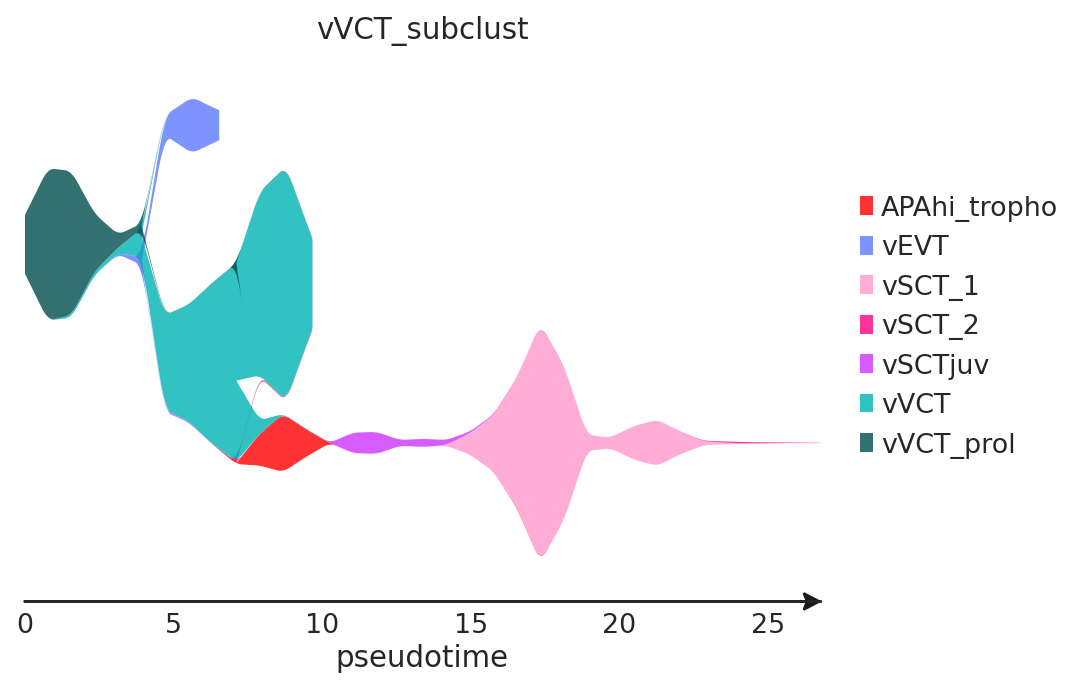

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,2)
sc.settings.set_figure_params(dpi=60)
st.set_figure_params(style='white', rc={'image.cmap': 'RdBu_r'})

#Figure-2A 
st.plot_stream(ldata_norm_int, root= 'S4', color= ['vVCT_subclust'], dist_scale=1.5)

In [8]:
ldata_norm_int.obs['celltype_v5']= ldata_norm_int.obs['vVCT_subclust'].astype('category')

col_clust= ['#ff0000','#5c7aff', '#ff99cc', '#ff0080', '#cc33ff', '#00b3b3', '#004d4d']

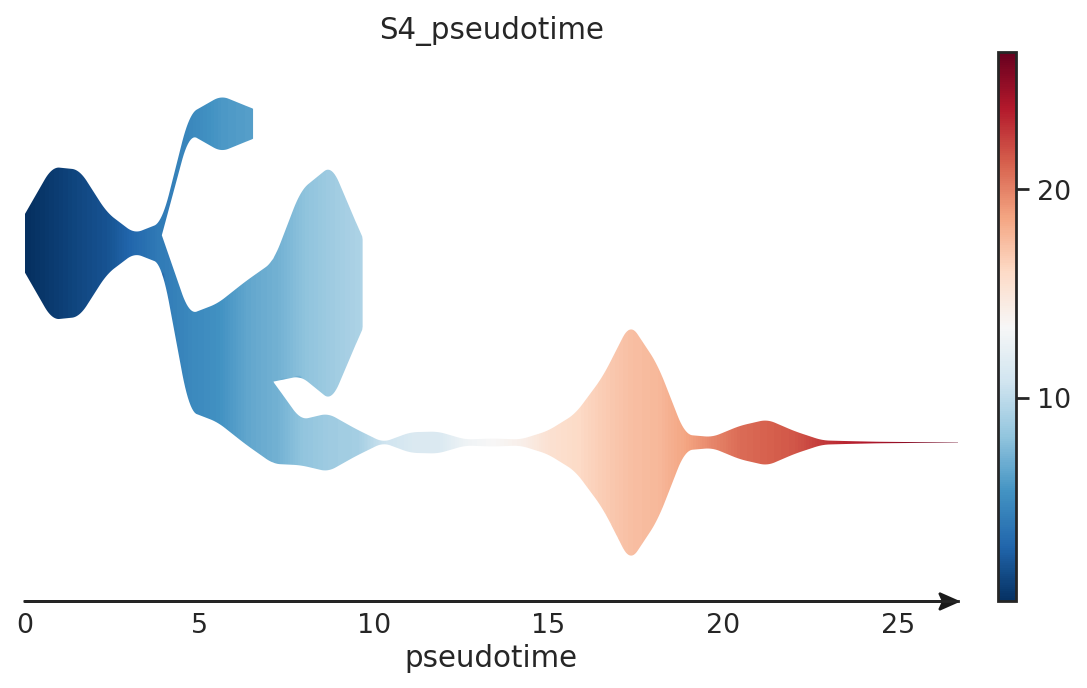

In [10]:
#Plot pseudotime values (Extended figure 4A):
st.plot_stream(ldata_norm_int, root= 'S4', color= ['S4_pseudotime'], dist_scale=1.5)

#vCTBp is set as "root" (or, start of trajectory) based on known trophoblast development. 

vCTBp was considered as the trophoblast progenitor as they are actively cycling given the expression of genes like MKI67, TOP2A, STMN1 and CENPK/CENPE. Notably, they exhibit robust expression of YAP1, TEAD1, TP63, CCNA2, ITGA6- all known for their roles as trophoblast progenitor (bipotent as it can differentiate towards both vSTB & vCCT lineages). 

In [11]:
#Subset vCCT or EVT lineage path: 
#Subset the branches leading to extravillous trophoblast starting from root node vCTBp:  
evt_clusters= [('S4', 'S3'), ('S5', 'S3')]

#Subset from normalized data: 
adata_evt= ldata_norm_int[ldata_norm_int.obs['branch_id_alias'].isin(evt_clusters)] 
adata_evt= adata_evt[adata_evt.obs['vVCT_subclust'].isin(['vVCT', 'vVCT_prol', 'vEVT', 'APAhi_tropho'])]
adata_evt.obs['vVCT_subclust'].value_counts()

vVCT_prol    9400
vEVT         2738
vVCT          233
Name: vVCT_subclust, dtype: int64

In [12]:
adata_evt.obs['celltype_v5']= adata_evt.obs['vVCT_subclust'].astype('category')
adata_evt.uns['celltype_v5_colors']= ['#5c7aff', '#00b3b3', '#004d4d']

Trying to set attribute `.obs` of view, copying.


In [14]:
adata_evt.X= adata_evt.X.toarray() #important step

In [15]:
import seaborn as sns

/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  war

Text(0.5, 0, 'Cell-to-cell distance')

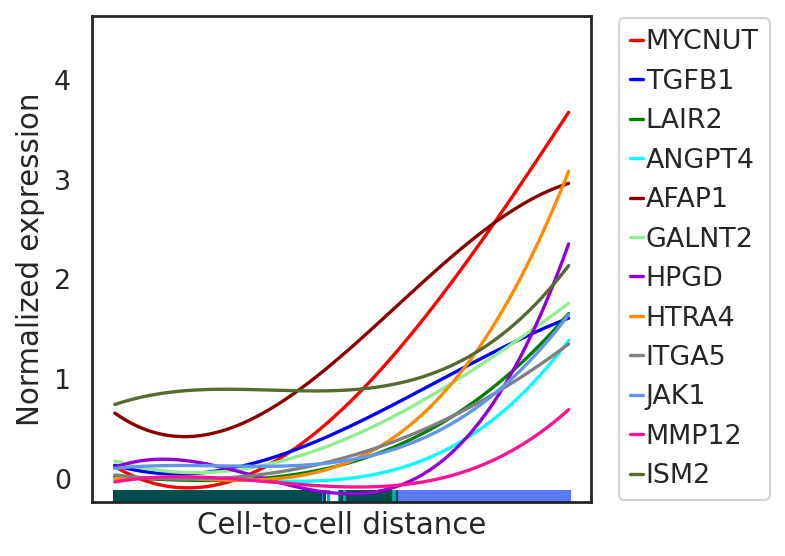

In [16]:
#Finalize the transition gene plot for vCCT (Extended Data figure 4F):
#combined with proteomics validated developmental features (features chosen upon discussion with Daniela Valdes): 
evt_genes= ['MYCNUT', 'TGFB1', 'LAIR2', 'ANGPT4', 'AFAP1', 'GALNT2', 'HPGD', 'HTRA4', 'ITGA5', 'JAK1', 'MMP12', 'ISM2']

df=pd.DataFrame(adata_evt[:,evt_genes].copy().X,columns=evt_genes)

df['pseudotime']= adata_evt.obs['S4_pseudotime'].values
df['clusters']= adata_evt.obs['celltype_v5'].values
df=df.sort_values(by='pseudotime',ascending=True)

#df.head()

col_clust= ['#5c7aff', '#00b3b3', '#004d4d']
plt.rcParams['figure.figsize'] = (4, 4)
fig,ax=plt.subplots()

cols=['red','blue','green','cyan','darkred','lightgreen','darkviolet','darkorange',
      'grey','cornflowerblue', 'deeppink', 'darkolivegreen', 'yellow', 'lightsalmon']

for i,gene in enumerate(evt_genes):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)
    
    sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i],ax=ax,label=gene)
for i,clust in enumerate(adata_evt.obs['celltype_v5'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sns.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax, color=col_clust[i])

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylim(-.05 * ax.get_ylim()[1])

#plt.ylim(0, 5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Normalized expression')
plt.xlabel('Cell-to-cell distance')
#plt.savefig("./vVCTp_transition_plots_1803/vCCT_lineage_transition_proteomics_MYCNUT_v4_100622.pdf", dpi=600, papertype= "executive", bbox_inches='tight')

In [17]:
#Save the individual stream plots too:
#st.plot_stream(ldata_norm_int, root= 'S4', color= ['MYCNUT', 'TGFB1', 'LAIR2', 'ANGPT4', 'AFAP1', 'GALNT2', 'HPGD', 
                                                   #'HTRA4', 'ITGA5', 'JAK1', 'MMP12', 'ISM2'], dist_scale=1, save_fig=True) #save_fig=True

/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  war

Text(0.5, 0, 'Cell-to-cell distance')

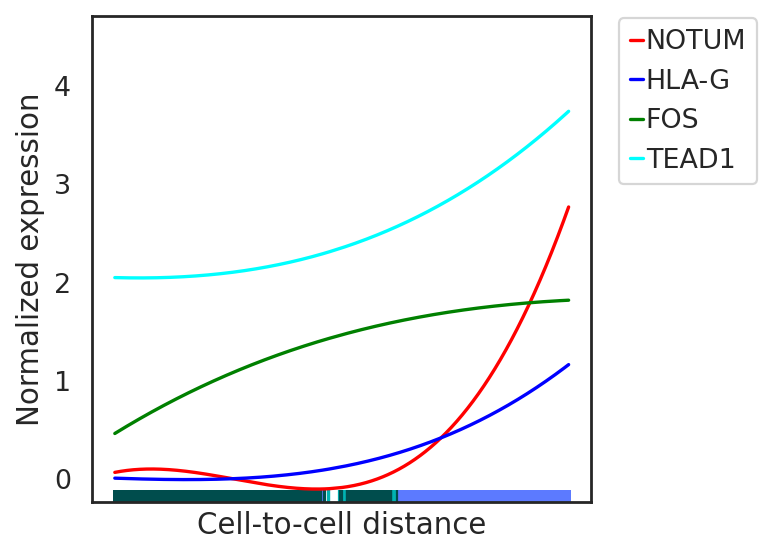

In [18]:
#Main figure 2D (transition markers validated in-vitro by Dr. Sandra Haider, Vienna): 

evt_genes= ['NOTUM', 'HLA-G', 'FOS', 'TEAD1']
df=pd.DataFrame(adata_evt[:,evt_genes].copy().X,columns=evt_genes)
df['pseudotime']= adata_evt.obs['S4_pseudotime'].values
df['clusters']= adata_evt.obs['celltype_v5'].values
df=df.sort_values(by='pseudotime',ascending=True)

col_clust= ['#5c7aff', '#00b3b3', '#004d4d']
plt.rcParams['figure.figsize'] = (4, 4)
fig,ax=plt.subplots()

cols=['red','blue','green','cyan','darkred','lightgreen','darkviolet','darkorange',
      'grey','cornflowerblue', 'deeppink', 'darkolivegreen', 'yellow', 'lightsalmon']

for i,gene in enumerate(evt_genes):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)
    
    sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i],ax=ax,label=gene)
for i,clust in enumerate(adata_evt.obs['celltype_v5'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sns.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax, color=col_clust[i])

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylim(-.05 * ax.get_ylim()[1])

#plt.ylim(0, 5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Normalized expression')
plt.xlabel('Cell-to-cell distance')

#Line-colors & widths were formatted on Adobe Illustrator (by Dr. Olivia Nonn). 

In [20]:
import scvelo as scv
#scv.logging.print_version()

In [21]:
#Plot vCCT pseudotime features validated using proteomics: 
evt_pseudotime_proteomics= ['ADAM19', 'AFAP1', 'ANGPT4', 'ASAP3', 'BAIAP2L1', 'COTL1', 'FLNB', 'GALNT2', 
                  'HLA-G', 'HPGD', 'HTRA4', 'IL2RB', 'ITGA5', 'JAK1', 'JPT1', 'LVRN', 'MMP12', 'MMP15', 'NOTUM', 
                  'PCSK6', 'QSOX1', 'ACAN', 'B2M', 'CTSL', 'EFHD2', 'EFNA1', 'FBLIM1', 'GBP2', 'GJA5', 'GREB1L', 
                  'HAPLN3', 'HMOX1', 'HSPA2', 'ISG15', 'KRT7', 'LRRC32', 'MX1', 'MXRA7', 'MYADM', 'N4BP3', 'NLRP2', 
                  'PIEZO1', 'PRG2', 'SERPINB9', 'SLC7A1', 'SLCO4A1', 'SRI', 'TAGLN2', 'TLE3', 'TRIM71', 'TUBB6', 'UGDH', 
                  'VASP', 'ZYX']

len(evt_pseudotime_proteomics)

54

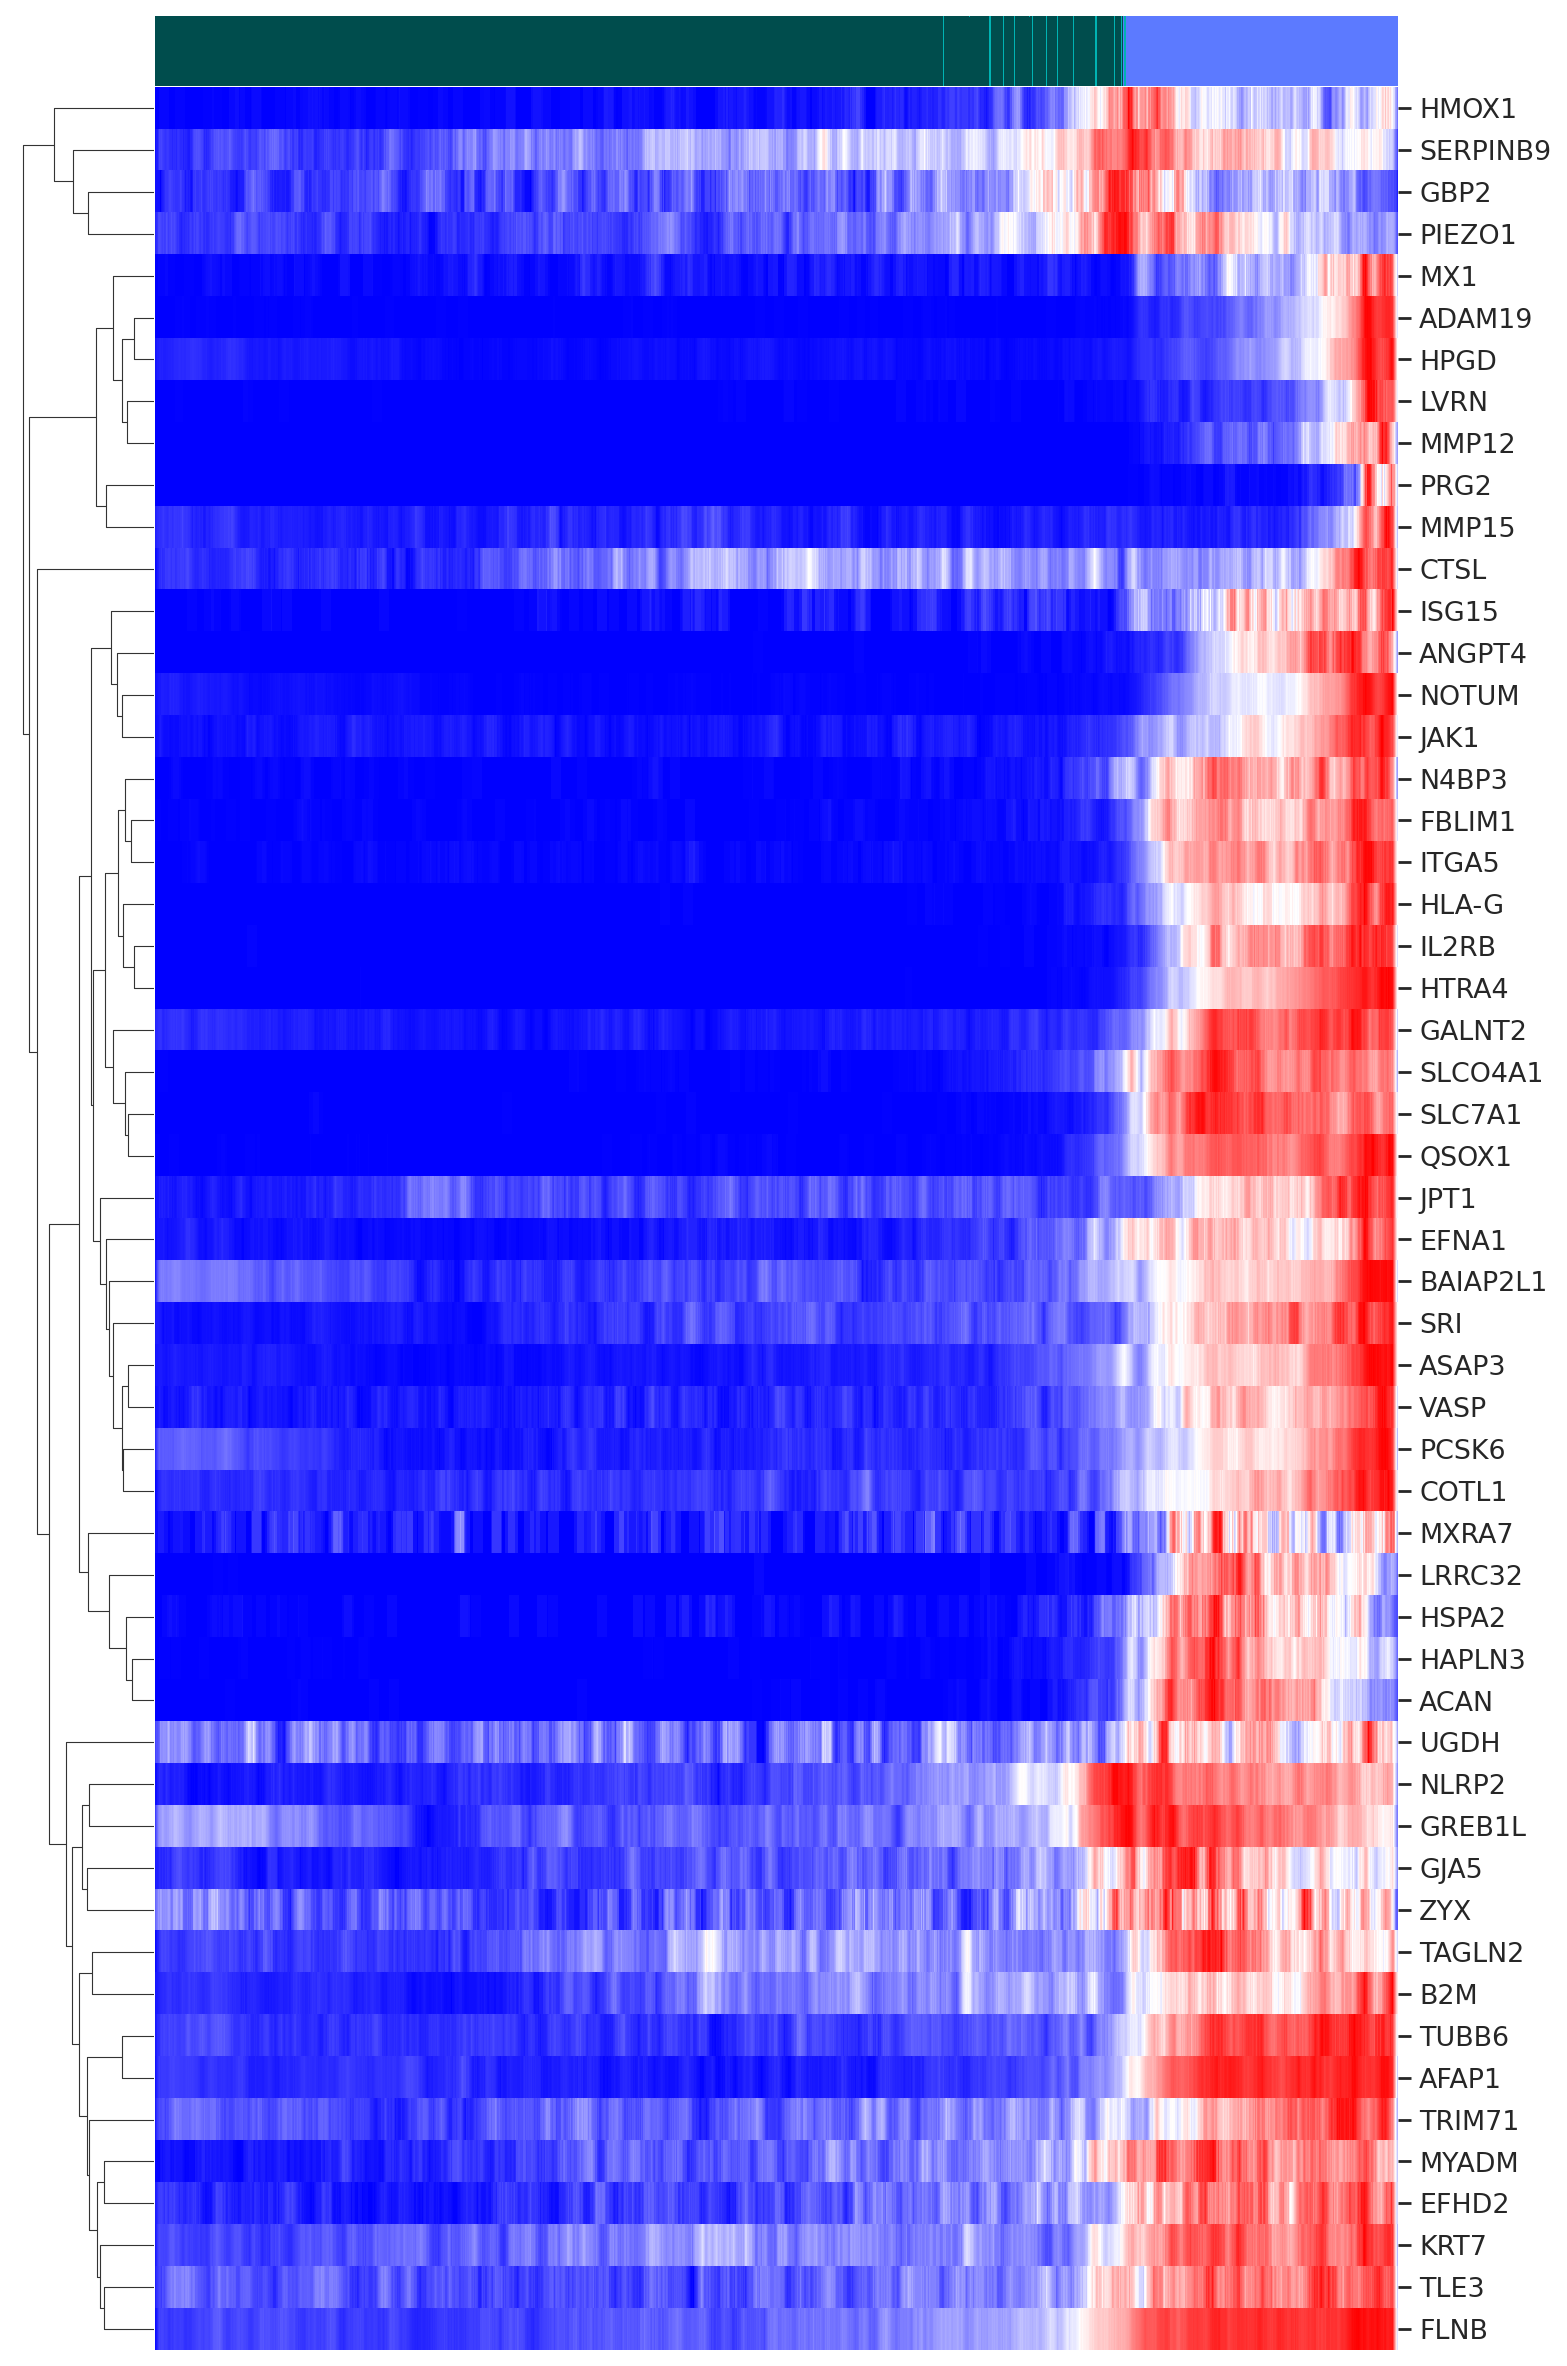

In [22]:
#Recapitulates what we know about the EVT differentiation. 
scv.pl.heatmap(adata_evt, var_names=evt_pseudotime_proteomics, sortby='S4_pseudotime', col_color='celltype_v5',
               n_convolve=100, figsize=(10, 15), color_map= 'bwr', row_cluster=True) #save= '_vCCT_leaf_proteomics_100622.pdf'

In [23]:
#Subset SCT lineage:
sct_clusters= [('S4', 'S3'), ('S3', 'S0'), ('S2', 'S0')]
adata_sct= ldata_norm_int[ldata_norm_int.obs['branch_id_alias'].isin(sct_clusters)]
adata_sct.obs['branch_id_alias'].value_counts()

#Remove the 1 EVT from the SCT specific branch: 
adata_sct= adata_sct[adata_sct.obs['vVCT_subclust'] != 'vEVT'] 
adata_sct.obs['vVCT_subclust'].value_counts()

vSCT_1          16117
vVCT             9969
vVCT_prol        9246
APAhi_tropho     2634
vSCTjuv          1470
vSCT_2            104
Name: vVCT_subclust, dtype: int64

In [24]:
adata_sct.obs['celltype_v5']= adata_sct.obs['vVCT_subclust'].astype('category')

#Include the corresponding SCT lineage color codes: 
sct_col_clust= ['#ff0000',  '#ff99cc', '#ff0080', '#cc33ff', '#00b3b3', '#004d4d']

Trying to set attribute `.obs` of view, copying.


In [25]:
adata_sct.X= adata_sct.X.toarray() 

Text(0.5, 0, 'Cell-to-cell distance')

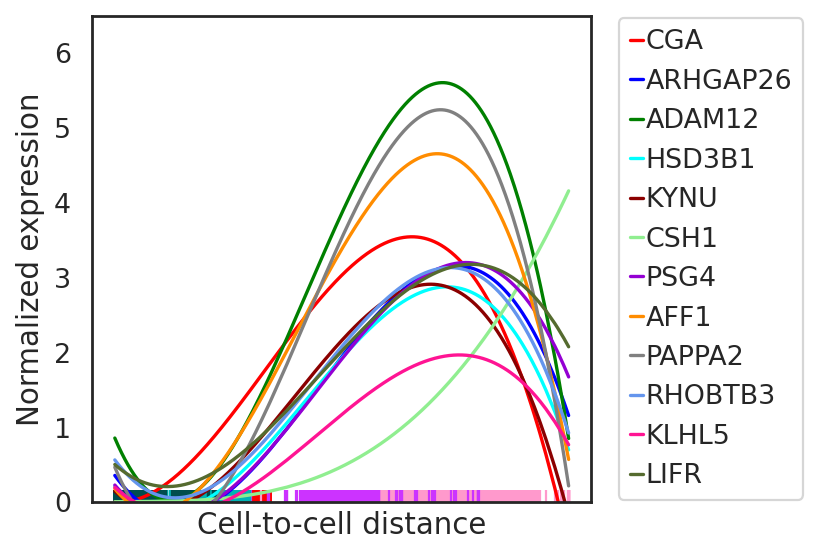

In [26]:
#vSTB lineage path: Extended Data figure 4G
sct_genes= ['CGA', 'ARHGAP26', 'ADAM12', 'HSD3B1', 'KYNU', 'CSH1', 'PSG4', 'AFF1', 'PAPPA2',
           'RHOBTB3', 'KLHL5', 'LIFR']

df=pd.DataFrame(adata_sct[:, sct_genes].copy().X,columns=sct_genes)
df['pseudotime']= adata_sct.obs['S4_pseudotime'].values
df['clusters']= adata_sct.obs['celltype_v5'].values
df=df.sort_values(by='pseudotime',ascending=True)

#Include the corresponding color codes: 
sct_col_clust= ['#ff0000',  '#ff99cc', '#ff99cc', '#cc33ff', '#00b3b3', '#004d4d']
plt.rcParams['figure.figsize'] = (4, 4)
fig,ax=plt.subplots()

cols=['red','blue','green','cyan','darkred','lightgreen','darkviolet','darkorange',
      'grey','cornflowerblue', 'deeppink', 'darkolivegreen', 'yellow', 'lightsalmon']

for i,gene in enumerate(sct_genes):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)
    
    
    sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i],ax=ax,label=gene)
for i,clust in enumerate(adata_sct.obs['celltype_v5'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sns.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax, color=sct_col_clust[i])

ax.set_xticks([])
ax.set_xticklabels([])
plt.ylim(0, 6.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Normalized expression')
plt.xlabel('Cell-to-cell distance')
#plt.savefig("./vVCTp_transition_plots_1803/vSTB_lineage_transition_proteomics_v5_150622.pdf", dpi=600, papertype= "executive", bbox_inches='tight')


Text(0.5, 0, 'Cell-to-cell distance')

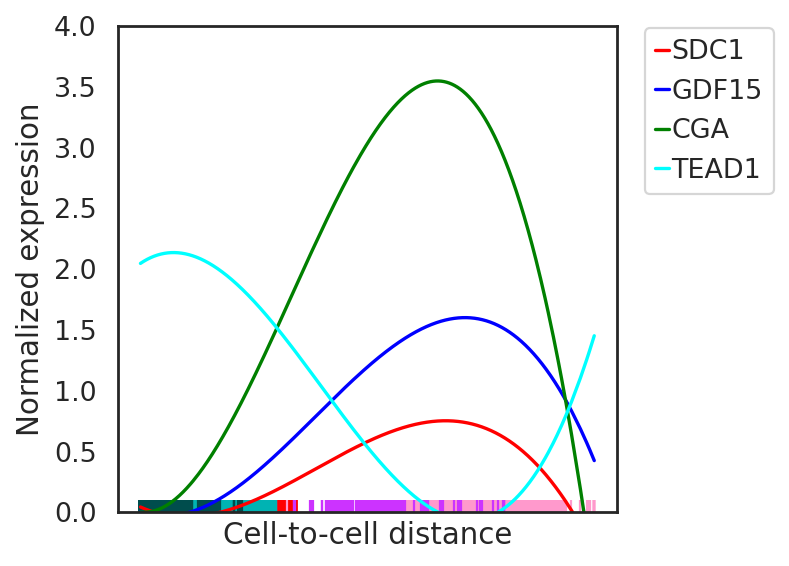

In [29]:
#vSTB lineage path: Main figure 2h. 
##Line-colors & widths were reformatted on Adobe Illustrator (by Dr. Olivia Nonn). 

sct_genes= ['SDC1', 'GDF15', 'CGA', 'TEAD1'] #TEAD1 is a negative regulator of vSTB differentiation path. 
df=pd.DataFrame(adata_sct[:, sct_genes].copy().X,columns=sct_genes)
df['pseudotime']= adata_sct.obs['S4_pseudotime'].values
df['clusters']= adata_sct.obs['celltype_v5'].values
df=df.sort_values(by='pseudotime',ascending=True)

#Include the corresponding color codes: 
sct_col_clust= ['#ff0000',  '#ff99cc', '#ff99cc', '#cc33ff', '#00b3b3', '#004d4d']
plt.rcParams['figure.figsize'] = (4, 4)
fig,ax=plt.subplots()

cols=['red','blue','green','cyan','darkred','lightgreen','darkviolet','darkorange',
      'grey','cornflowerblue', 'deeppink', 'darkolivegreen', 'yellow', 'lightsalmon']

for i,gene in enumerate(sct_genes):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)
    sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i],ax=ax,label=gene)
for i,clust in enumerate(adata_sct.obs['celltype_v5'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sns.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax, color=sct_col_clust[i])

ax.set_xticks([])
ax.set_xticklabels([])
plt.ylim(0, 4)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Normalized expression')
plt.xlabel('Cell-to-cell distance')

In [34]:
adata_sctjuv= adata_sct[adata_sct.obs['celltype_v5']== 'vSCTjuv']        
adata_sctjuv_filter = adata_sctjuv[adata_sctjuv[: , 'CGA'].X > 0.5, :] 
adata_sctjuv_filter = adata_sctjuv[adata_sctjuv[: , 'AFF1'].X > 0.1, :] 
print(adata_sctjuv_filter.n_obs)

#Concatenate with the rest:
adata_sct_rest= adata_sct[adata_sct.obs['celltype_v5'].isin(['APAhi_tropho', 'vSCT_1', 'vSCT_2', 'vVCT', 'vVCT_prol'])] 
adata_sct_new= adata_sct_rest.concatenate(adata_sctjuv_filter)
adata_sct_new.obs['celltype_v5']= adata_sct_new.obs['vVCT_subclust'].astype('category')
#adata_sct_new.obs['celltype_v5'].value_counts()  
adata_sct_new.uns['celltype_v5_colors']= ['#ff0000',  '#ff99cc', '#ff99cc', '#cc33ff', '#00b3b3', '#004d4d']

1199


Flat tree plot, where trajectory branches are represented as straight lines and each dot represents a single nucleus. Assigned branches, branch lengths, and distances between nuclei are preserved from the space from which the trajectory was inferred. At first, the tree  structure learned from a higher-dimension UMAP space was approximated by linear segments (each represents a branch) and subsequently, mapped to a 2D plane based on an improvised version of the force-directed layout Fruchterman-Reingold algorithm.

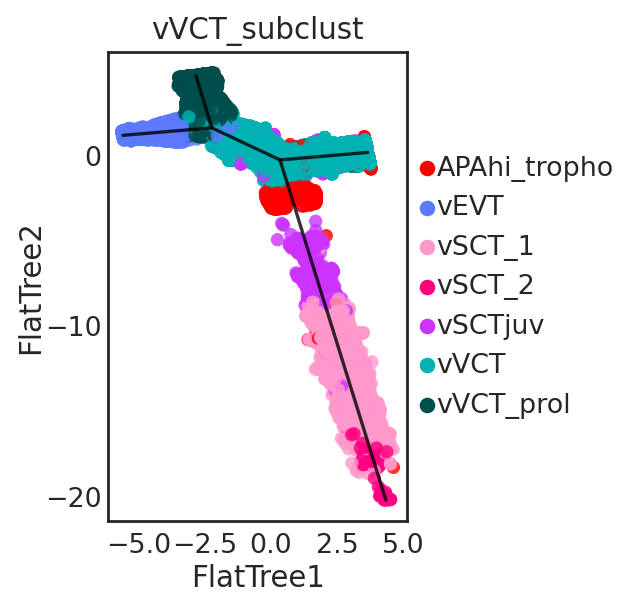

In [30]:
#Flat tree visualization (Extended Data figure 4C):
st.plot_flat_tree(ldata_norm_int, color= ['vVCT_subclust'], show_graph=True, show_text=False, dist_scale=0.5)

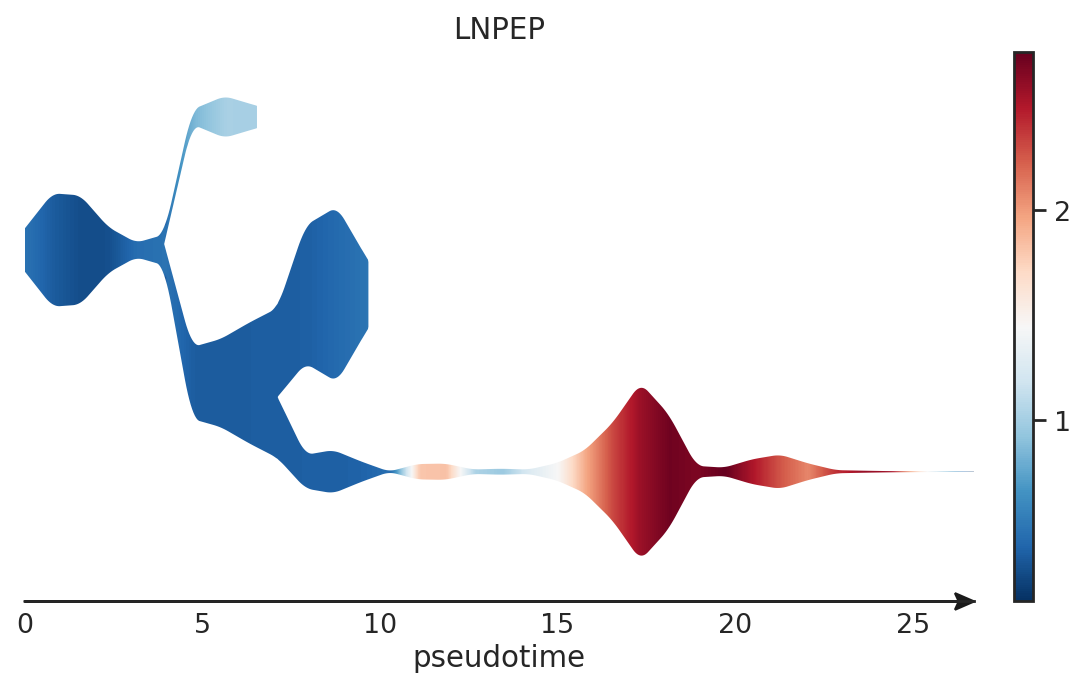

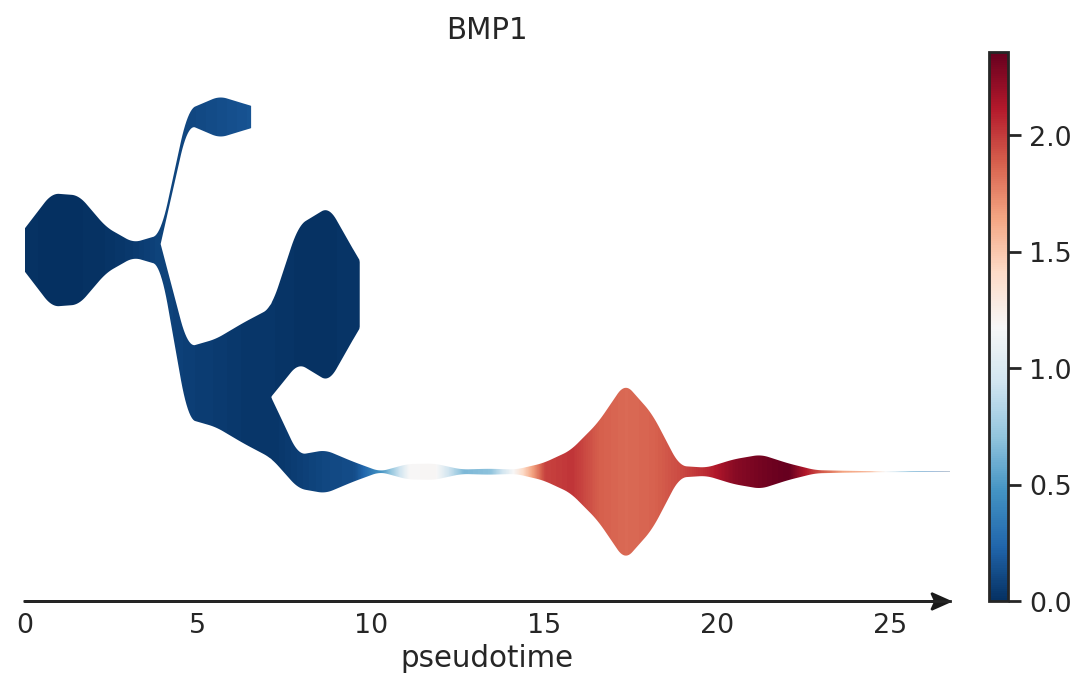

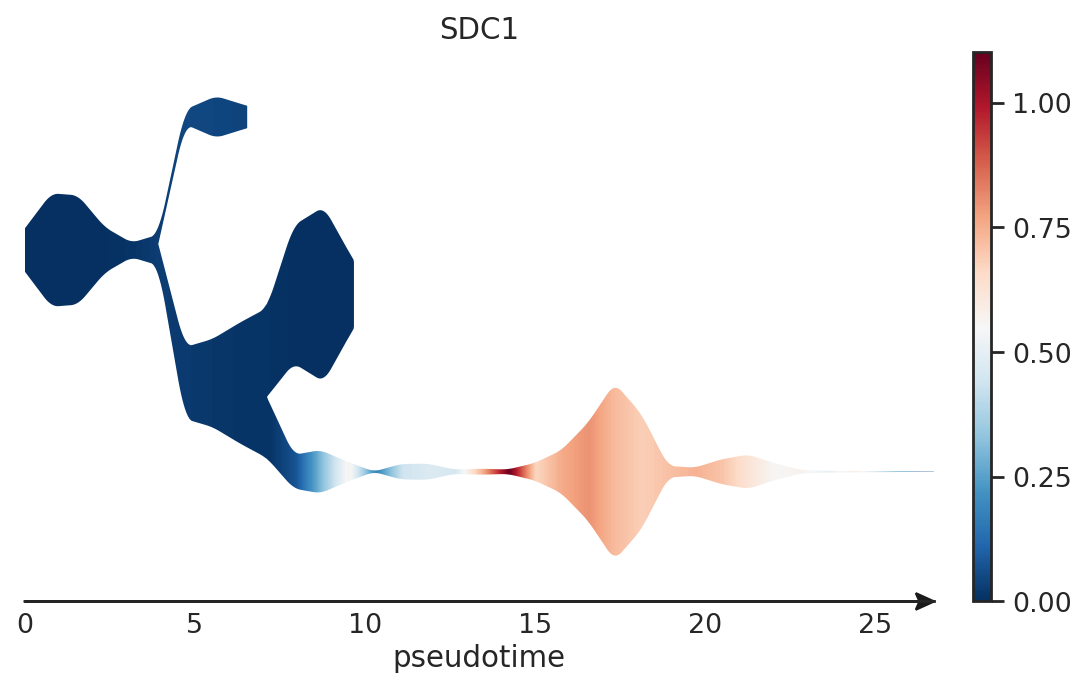

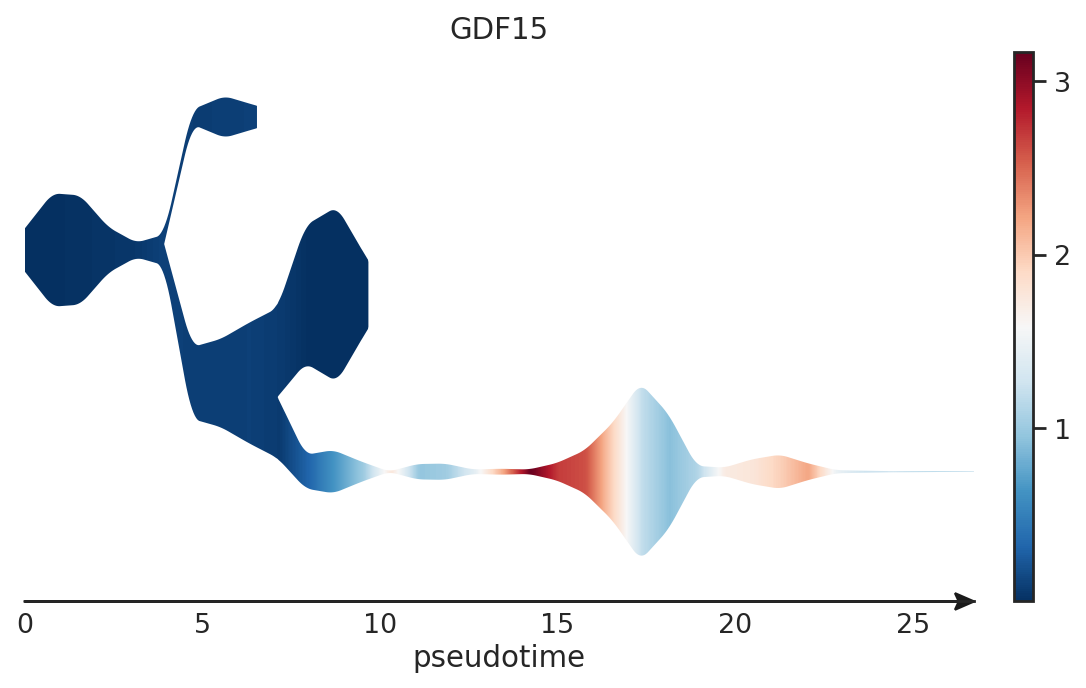

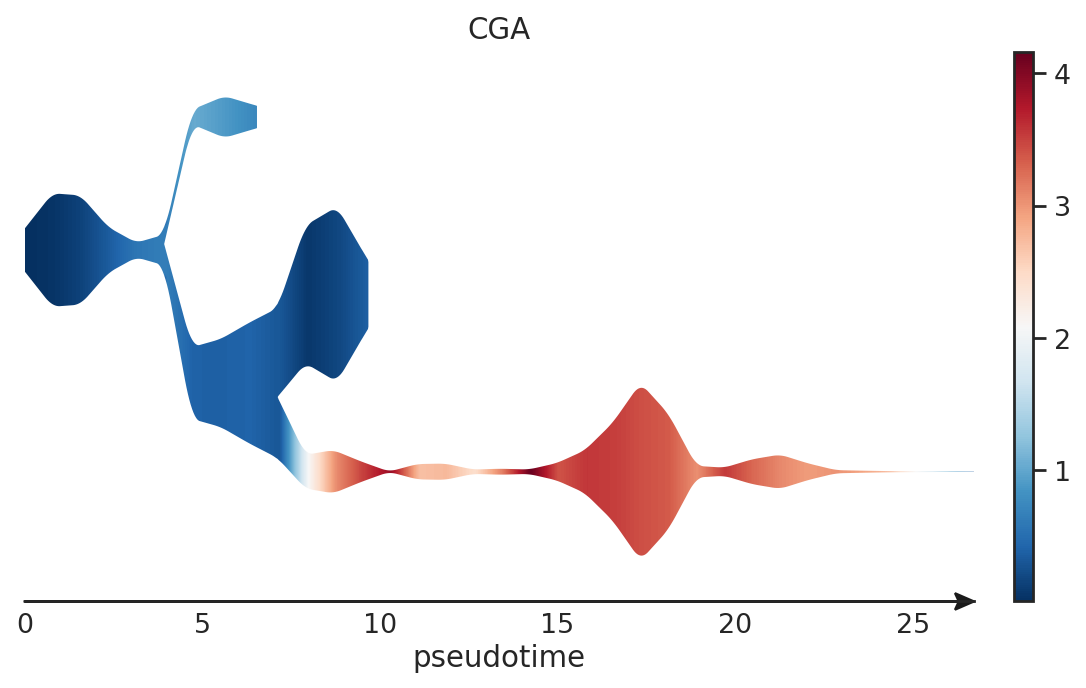

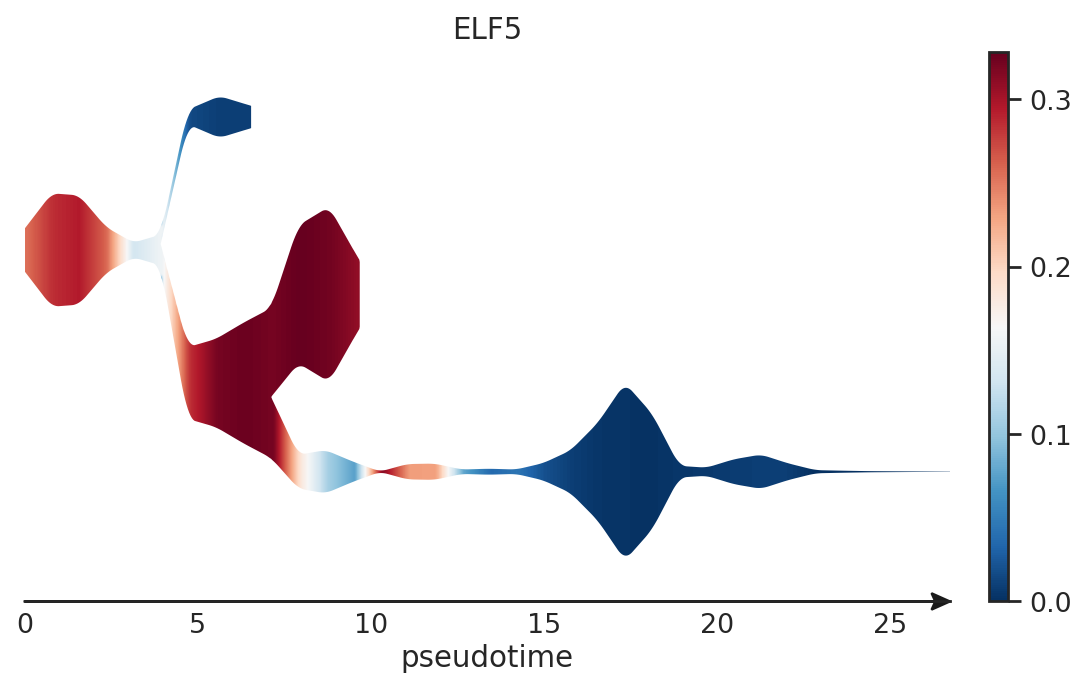

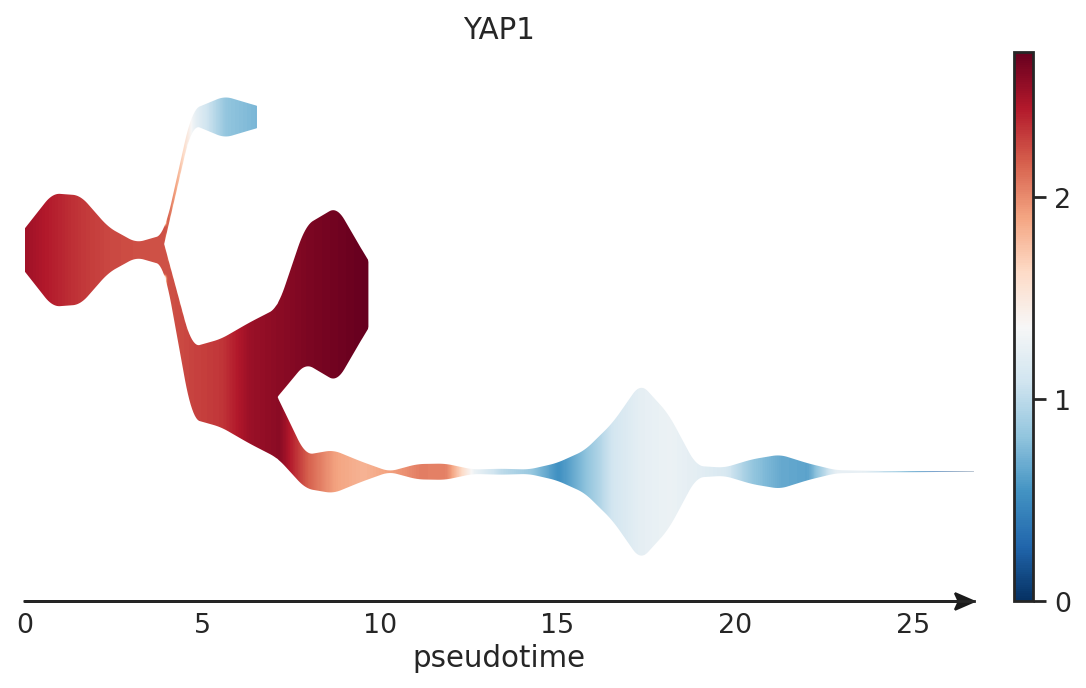

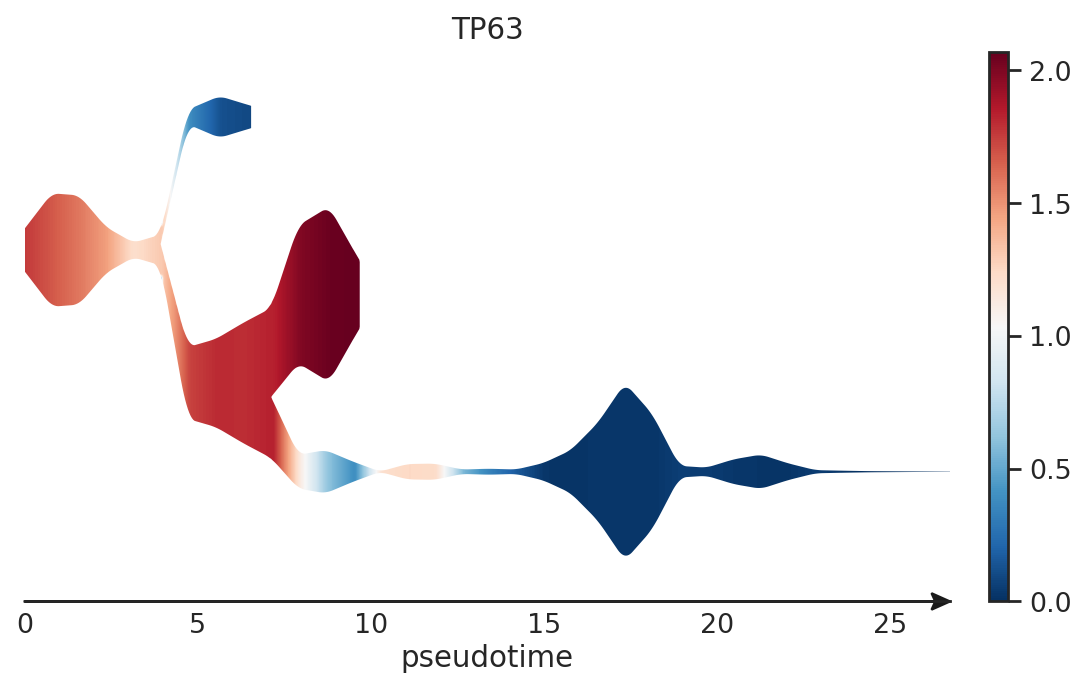

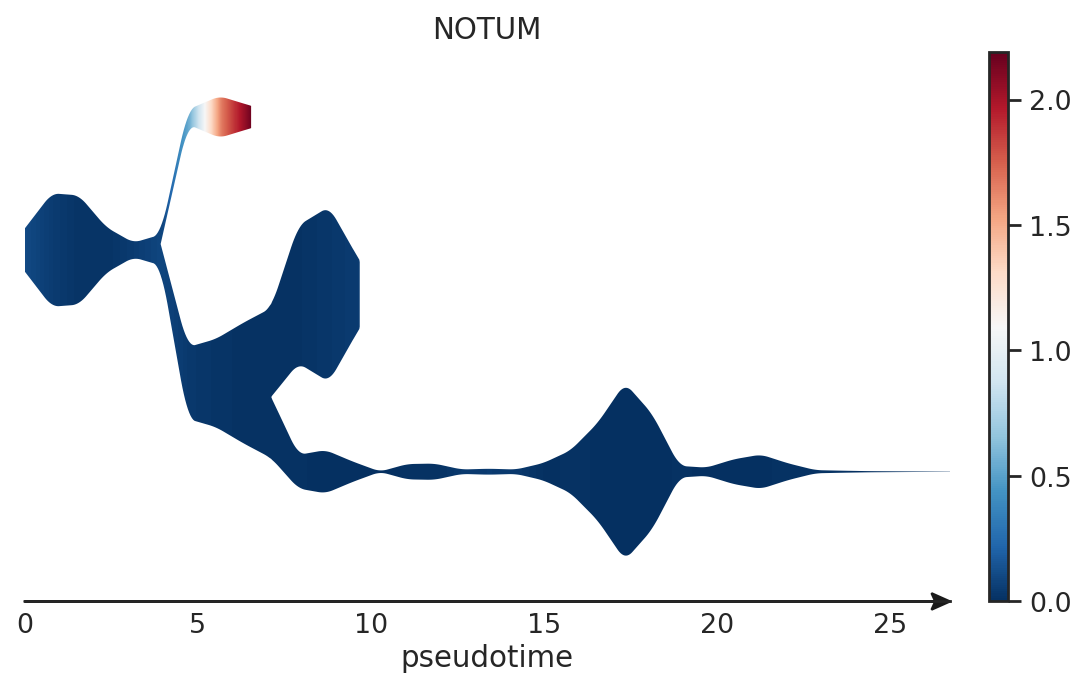

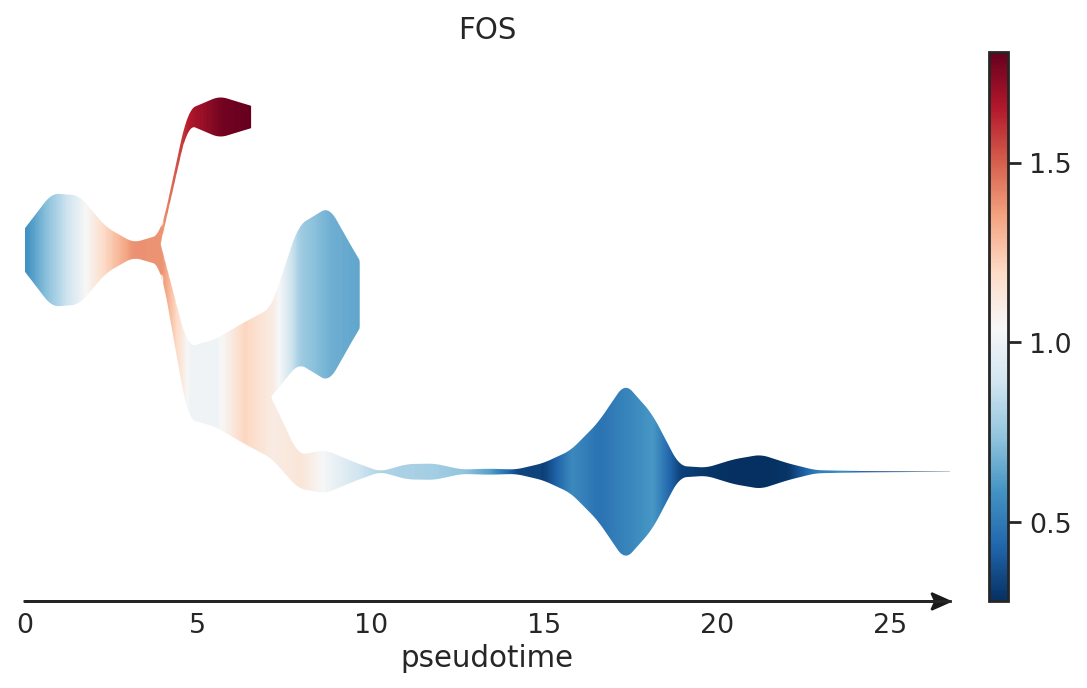

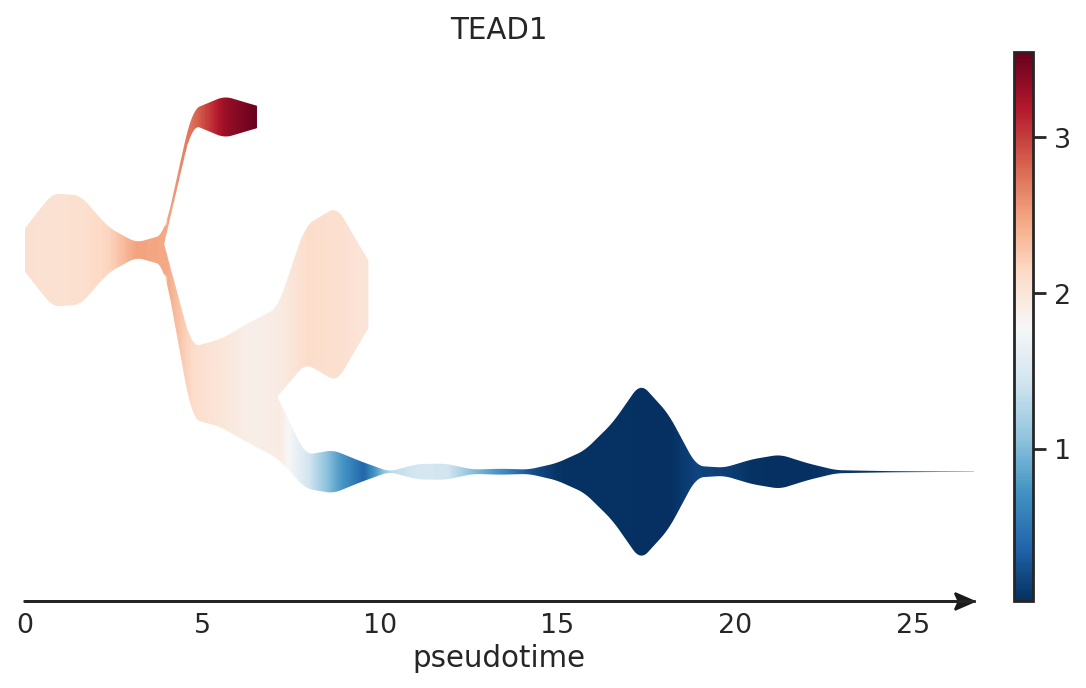

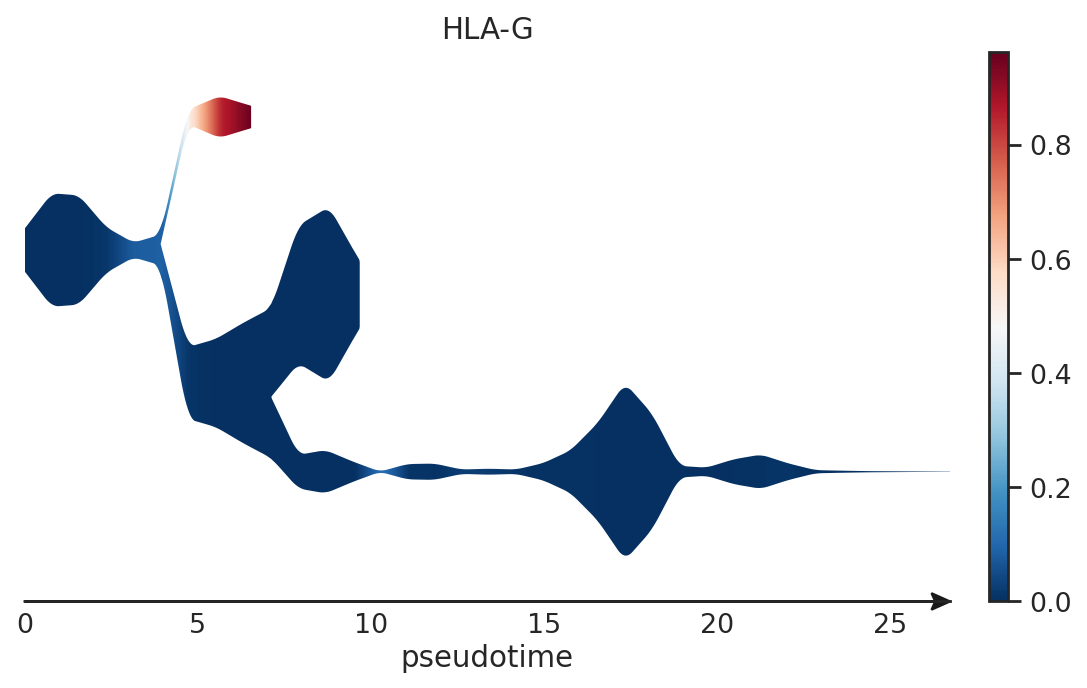

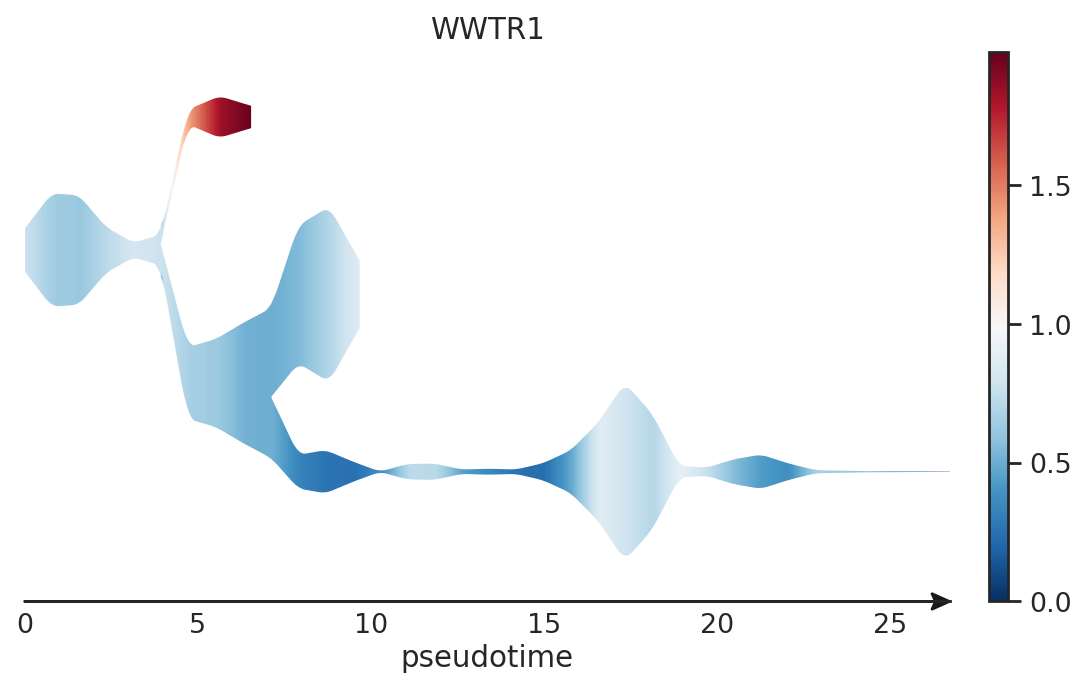

In [31]:
#Extended figure 4D: Individual stream plots of selected differentiation genes:
st.plot_stream(ldata_norm_int, root= 'S4', color= ['LNPEP', 'BMP1', 'SDC1', 'GDF15', 'CGA', 
                'ELF5', 'YAP1', 'TP63', 'NOTUM', 'FOS', 'TEAD1', 'HLA-G', 'WWTR1'], dist_scale=1)

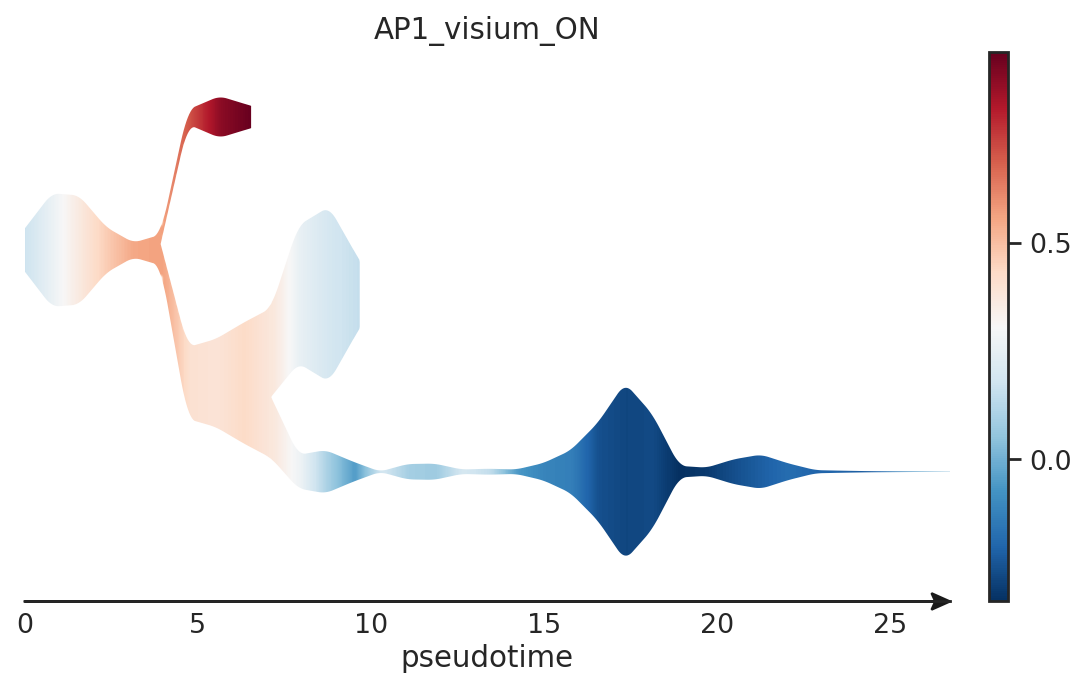

In [32]:
#Plot AP1 pathway candidates (synchronize with visium; extended figure-4D)
AP1_visium_ON= ['FOS', 'FOSL1', 'JUN'] #'TEAD1' 
sc.tl.score_genes(ldata_norm_int, AP1_visium_ON, score_name= 'AP1_visium_ON')
st.plot_stream(ldata_norm_int, root= 'S4', color= ['AP1_visium_ON'], dist_scale=1)

Fix for color-bars:
    
if "cbar_pos" not in kwargs or not colorbar:
        kwargs["cbar_pos"] = None
        
Based on these two lines, we need to set both cbar_pos and colorbar parameters to make the color bar appear.

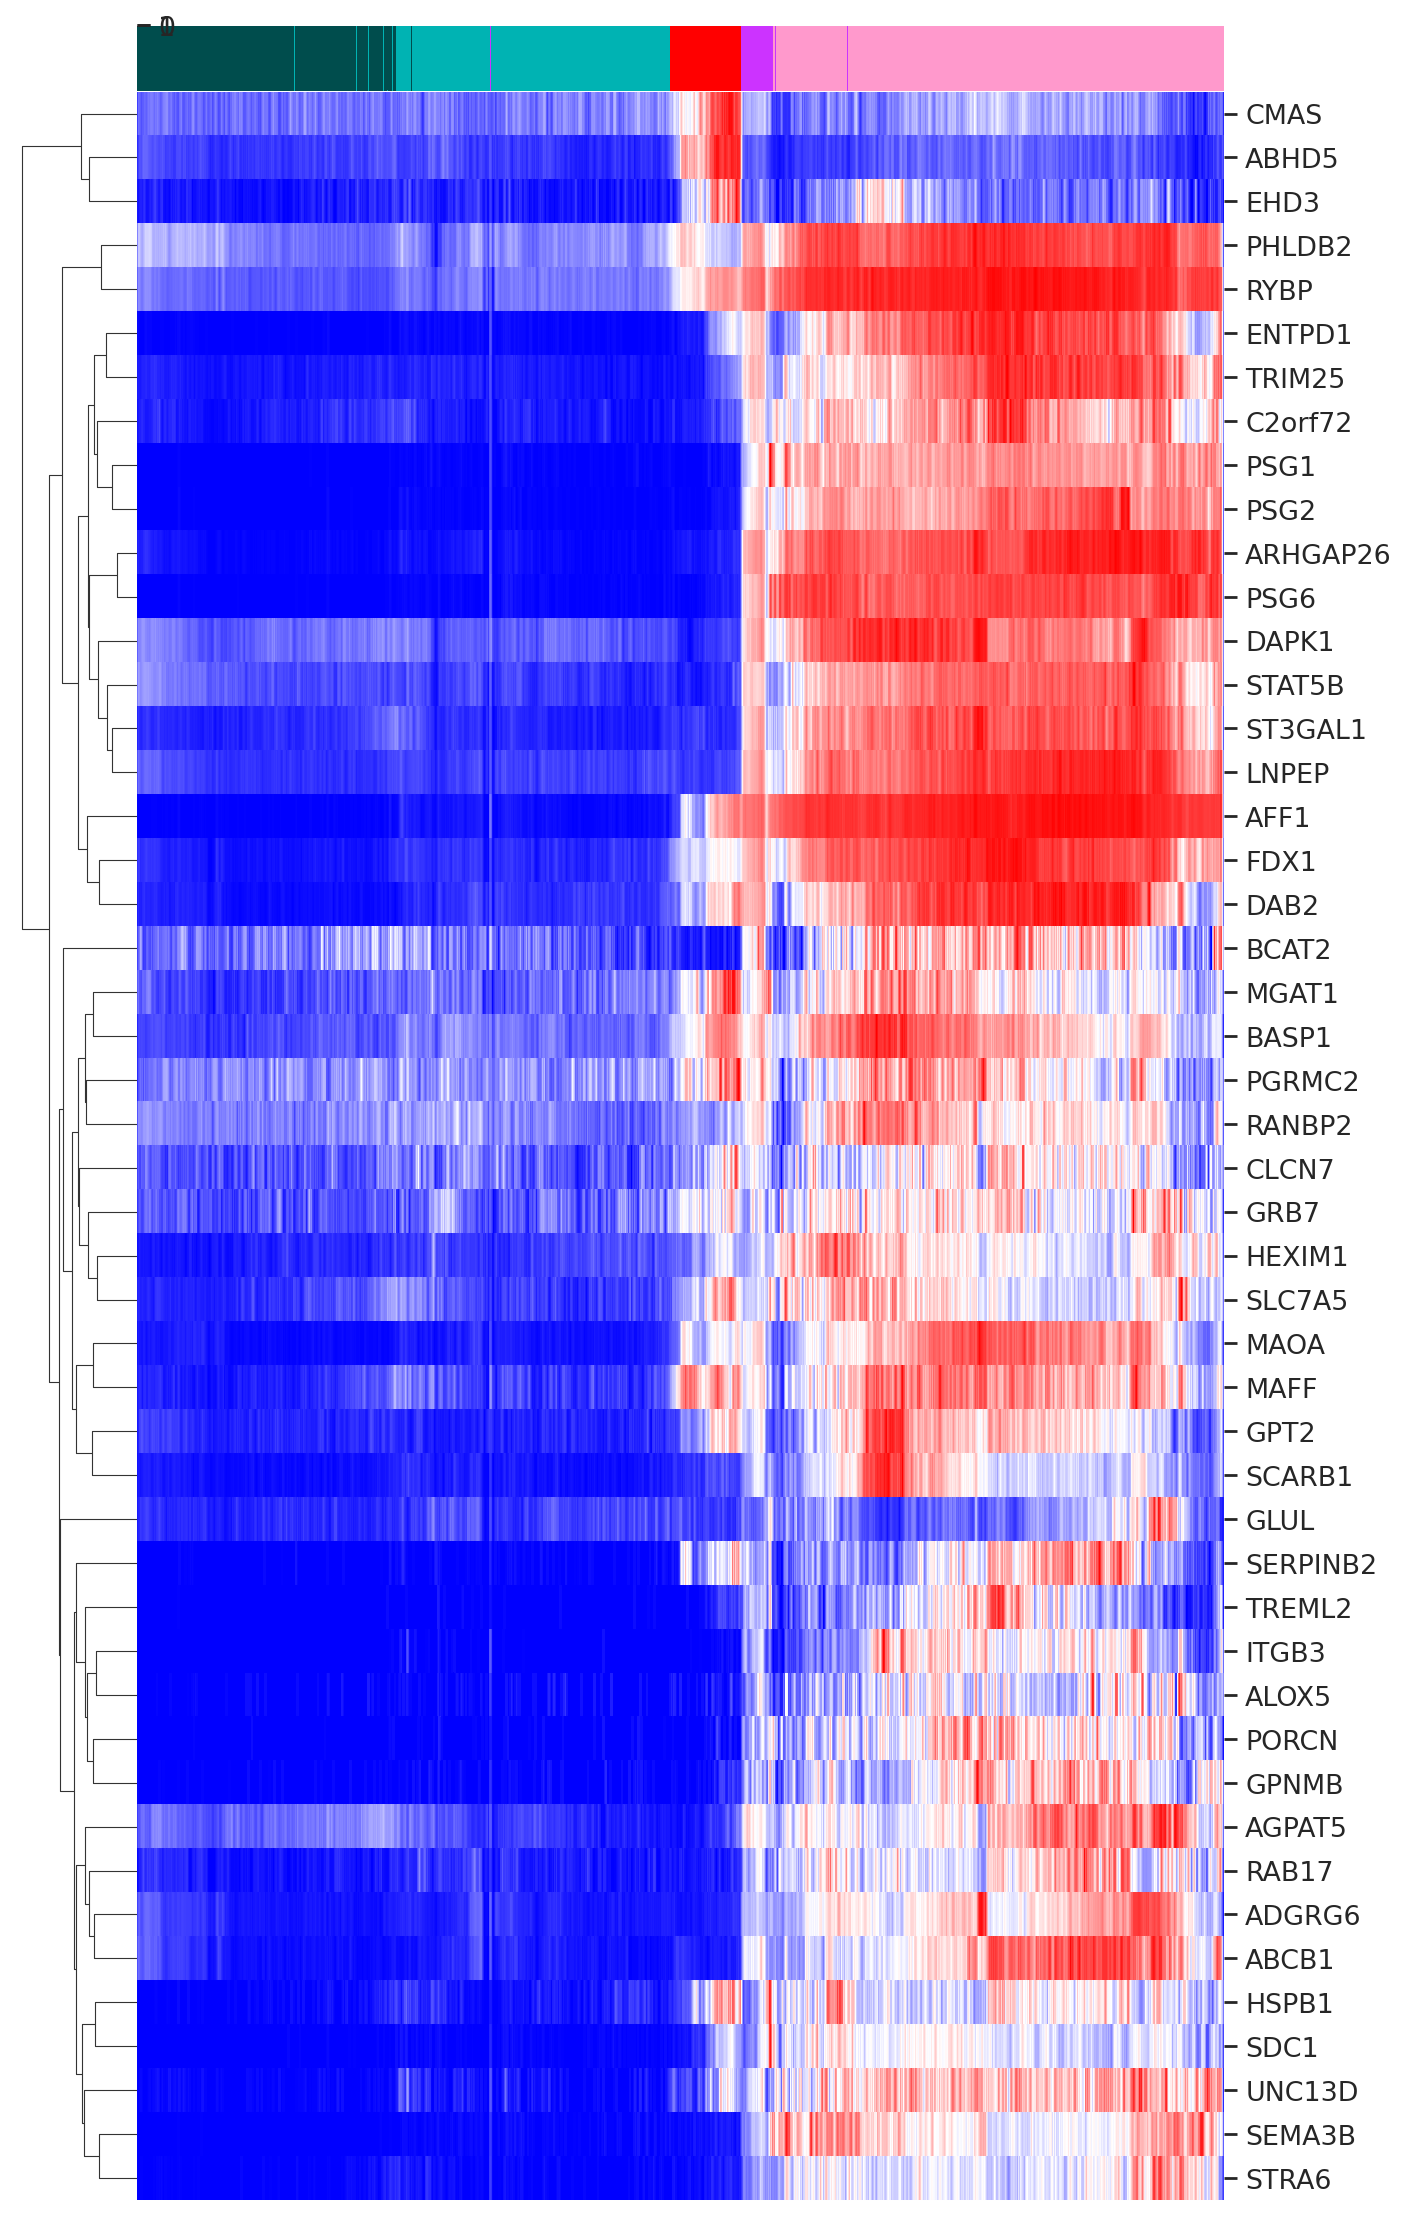

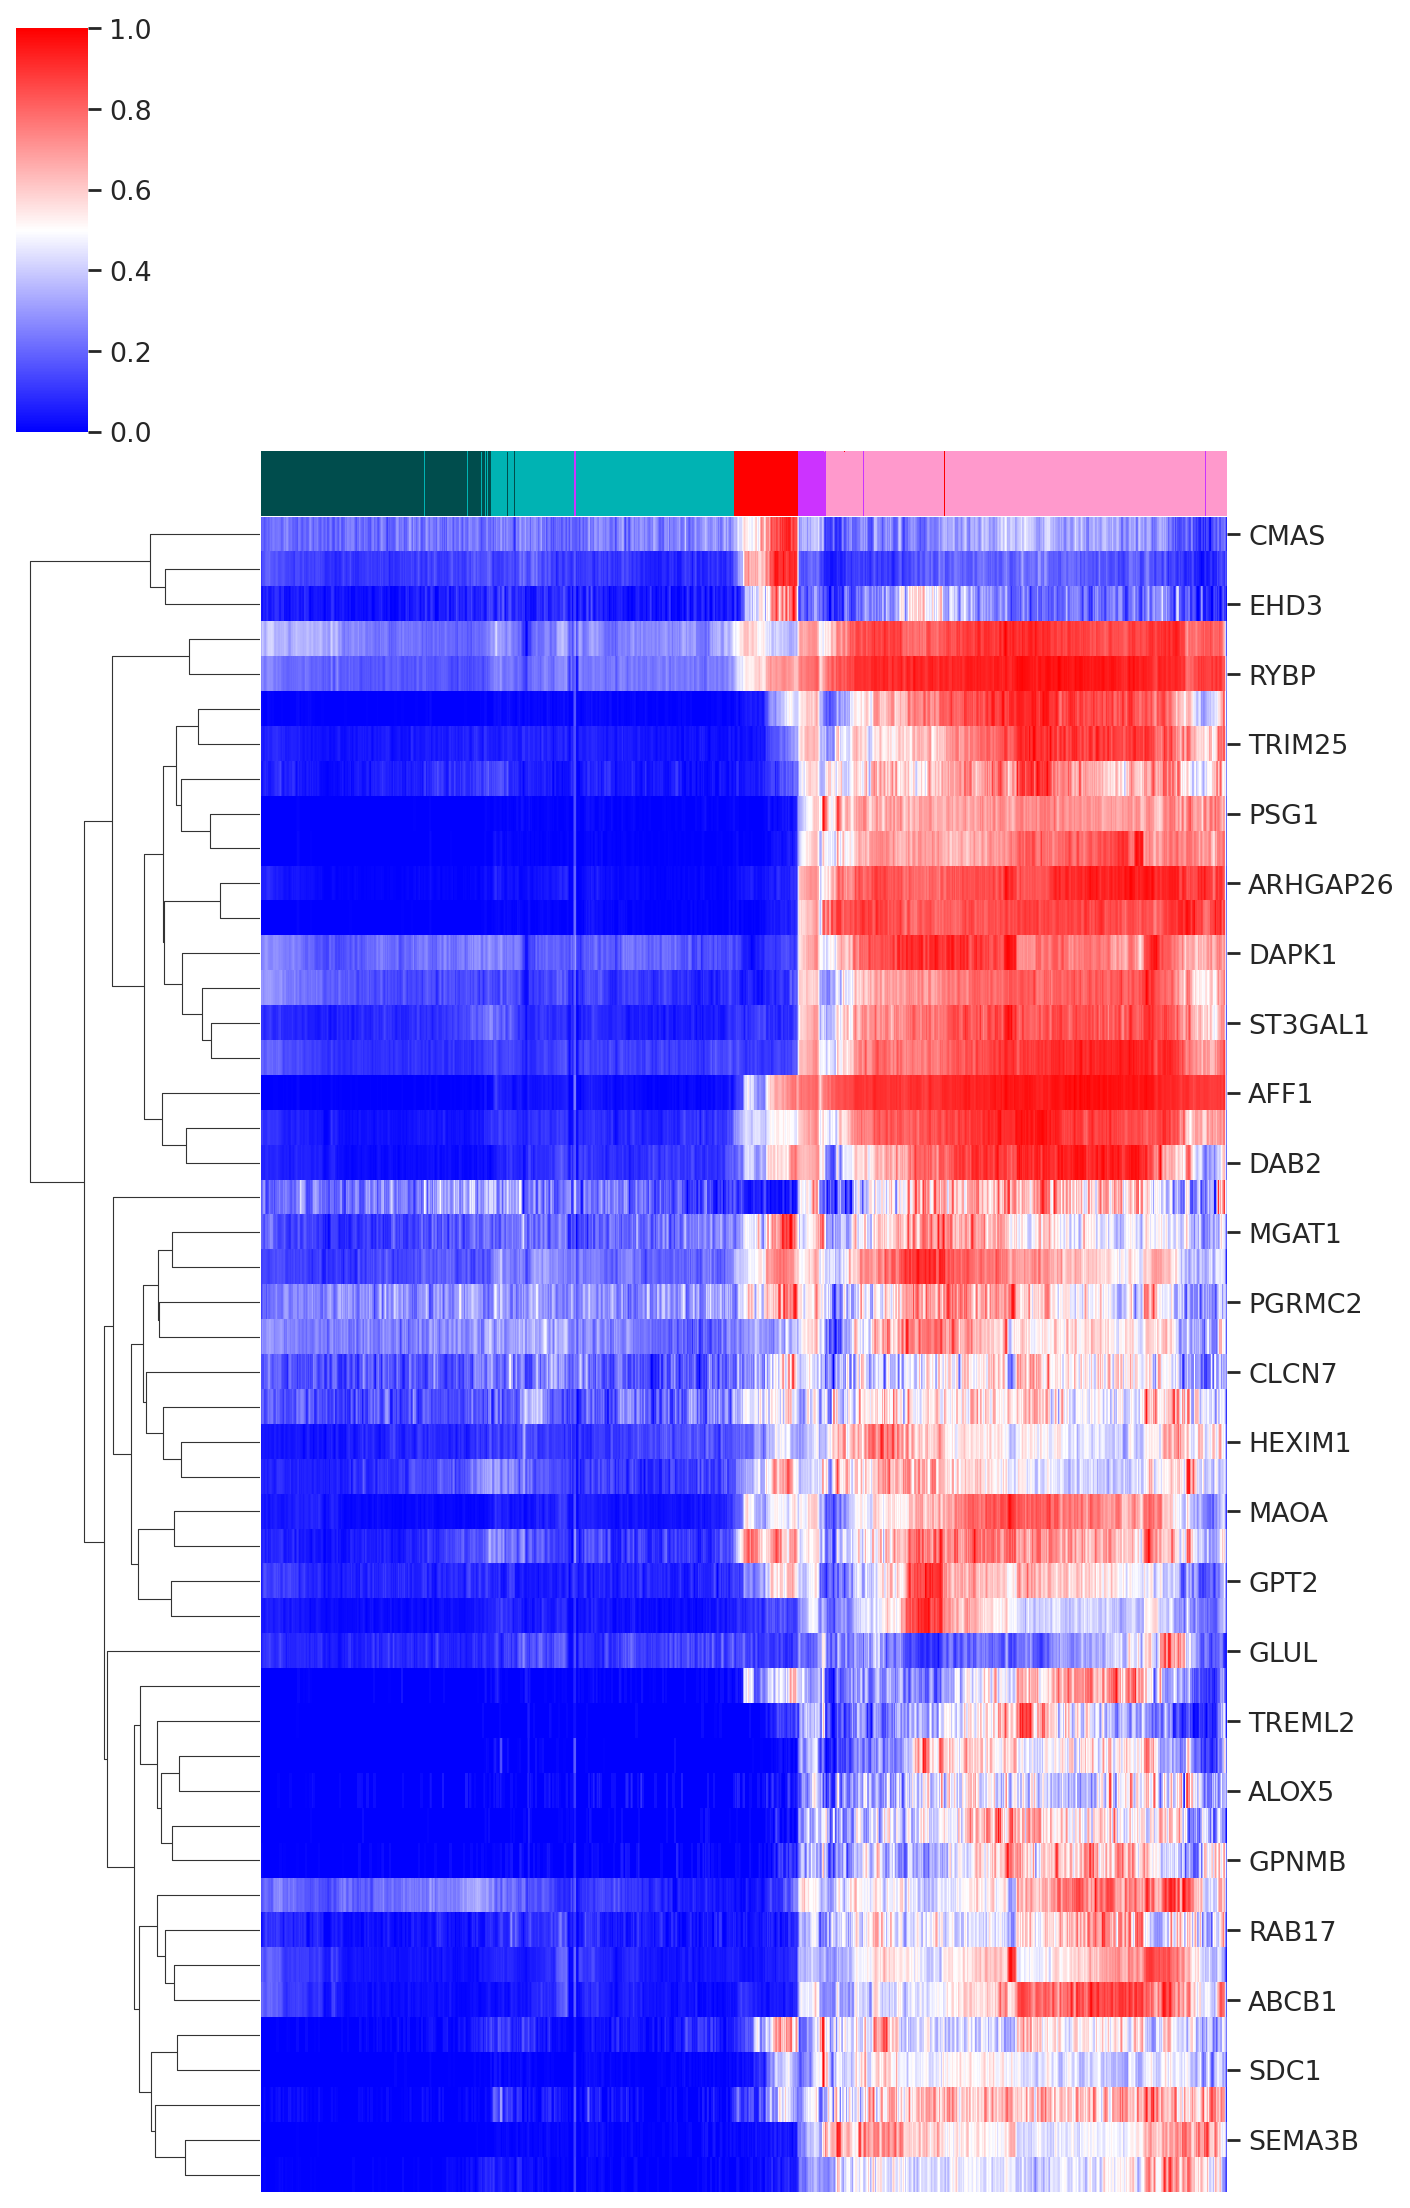

In [41]:
#Plot vSTB pseudotime features validated using proteomics (Extended figure-4i):
sct_list= ['ABCB1', 'AFF1', 'AGPAT5', 'ARHGAP26', 'DAB2', 'DAPK1', 'ENTPD1', 'FDX1', 'LNPEP', 'PSG1', 'PSG2', 'PSG6', 'RYBP', 'STAT5B', 'TRIM25', 'ADGRG6', 'PHLDB2', 
            'ST3GAL1', 'ABHD5', 'ALOX5', 'BASP1', 'BCAT2', 'C2orf72', 'CLCN7', 'CMAS', 'EHD3', 'GLUL', 'GPNMB', 'GPT2', 'GRB7', 'HEXIM1', 
            'HSPB1', 'ITGB3', 'MAFF', 'MAOA', 'MGAT1', 'PGRMC2', 'PORCN', 'RAB17', 'RANBP2', 
            'SCARB1', 'SDC1', 'SEMA3B', 'SERPINB2', 'SLC7A5', 'STRA6', 'TREML2', 'UNC13D']


#Print the colorbar:
scv.pl.heatmap(adata_sct_new, var_names= sct_list, sortby='S4_pseudotime', col_color='celltype_v5',
               n_convolve=100, figsize=(9, 14), color_map= 'bwr', row_cluster=True,
              cbar_pos=True, colorbar=True) #save= '_vSTB_pseudotime_proteomics_custom2_100622.pdf'


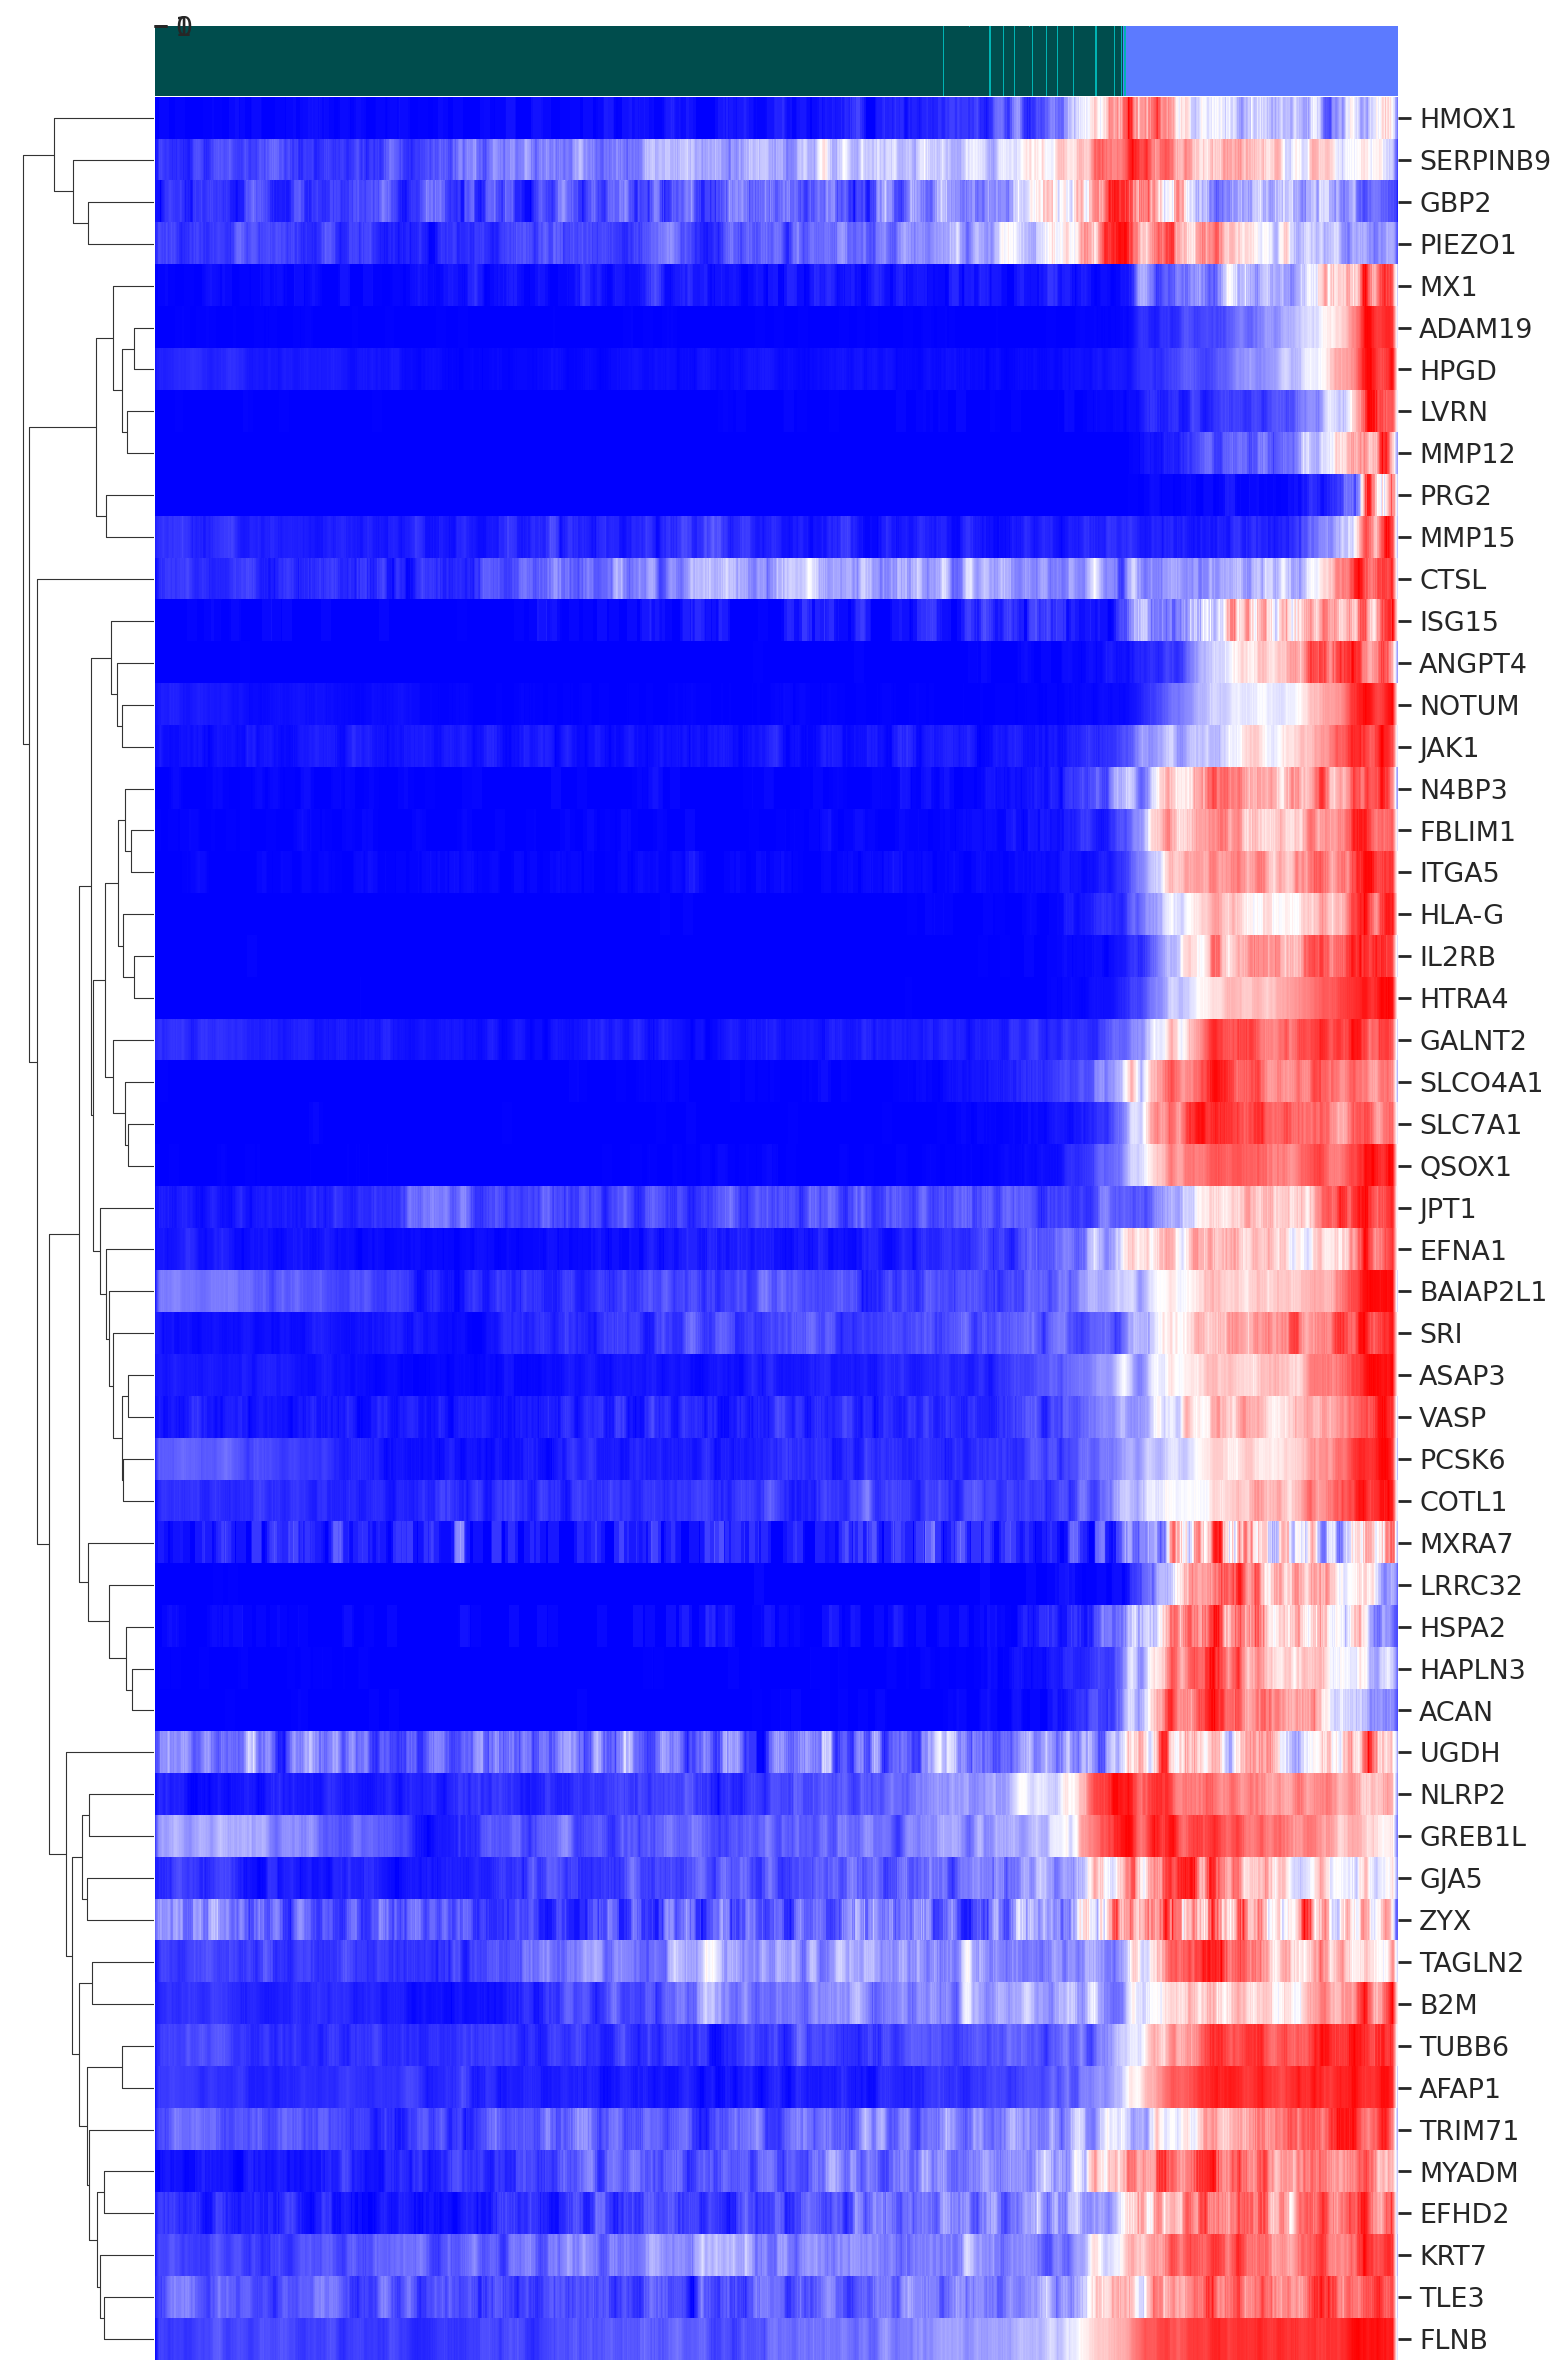

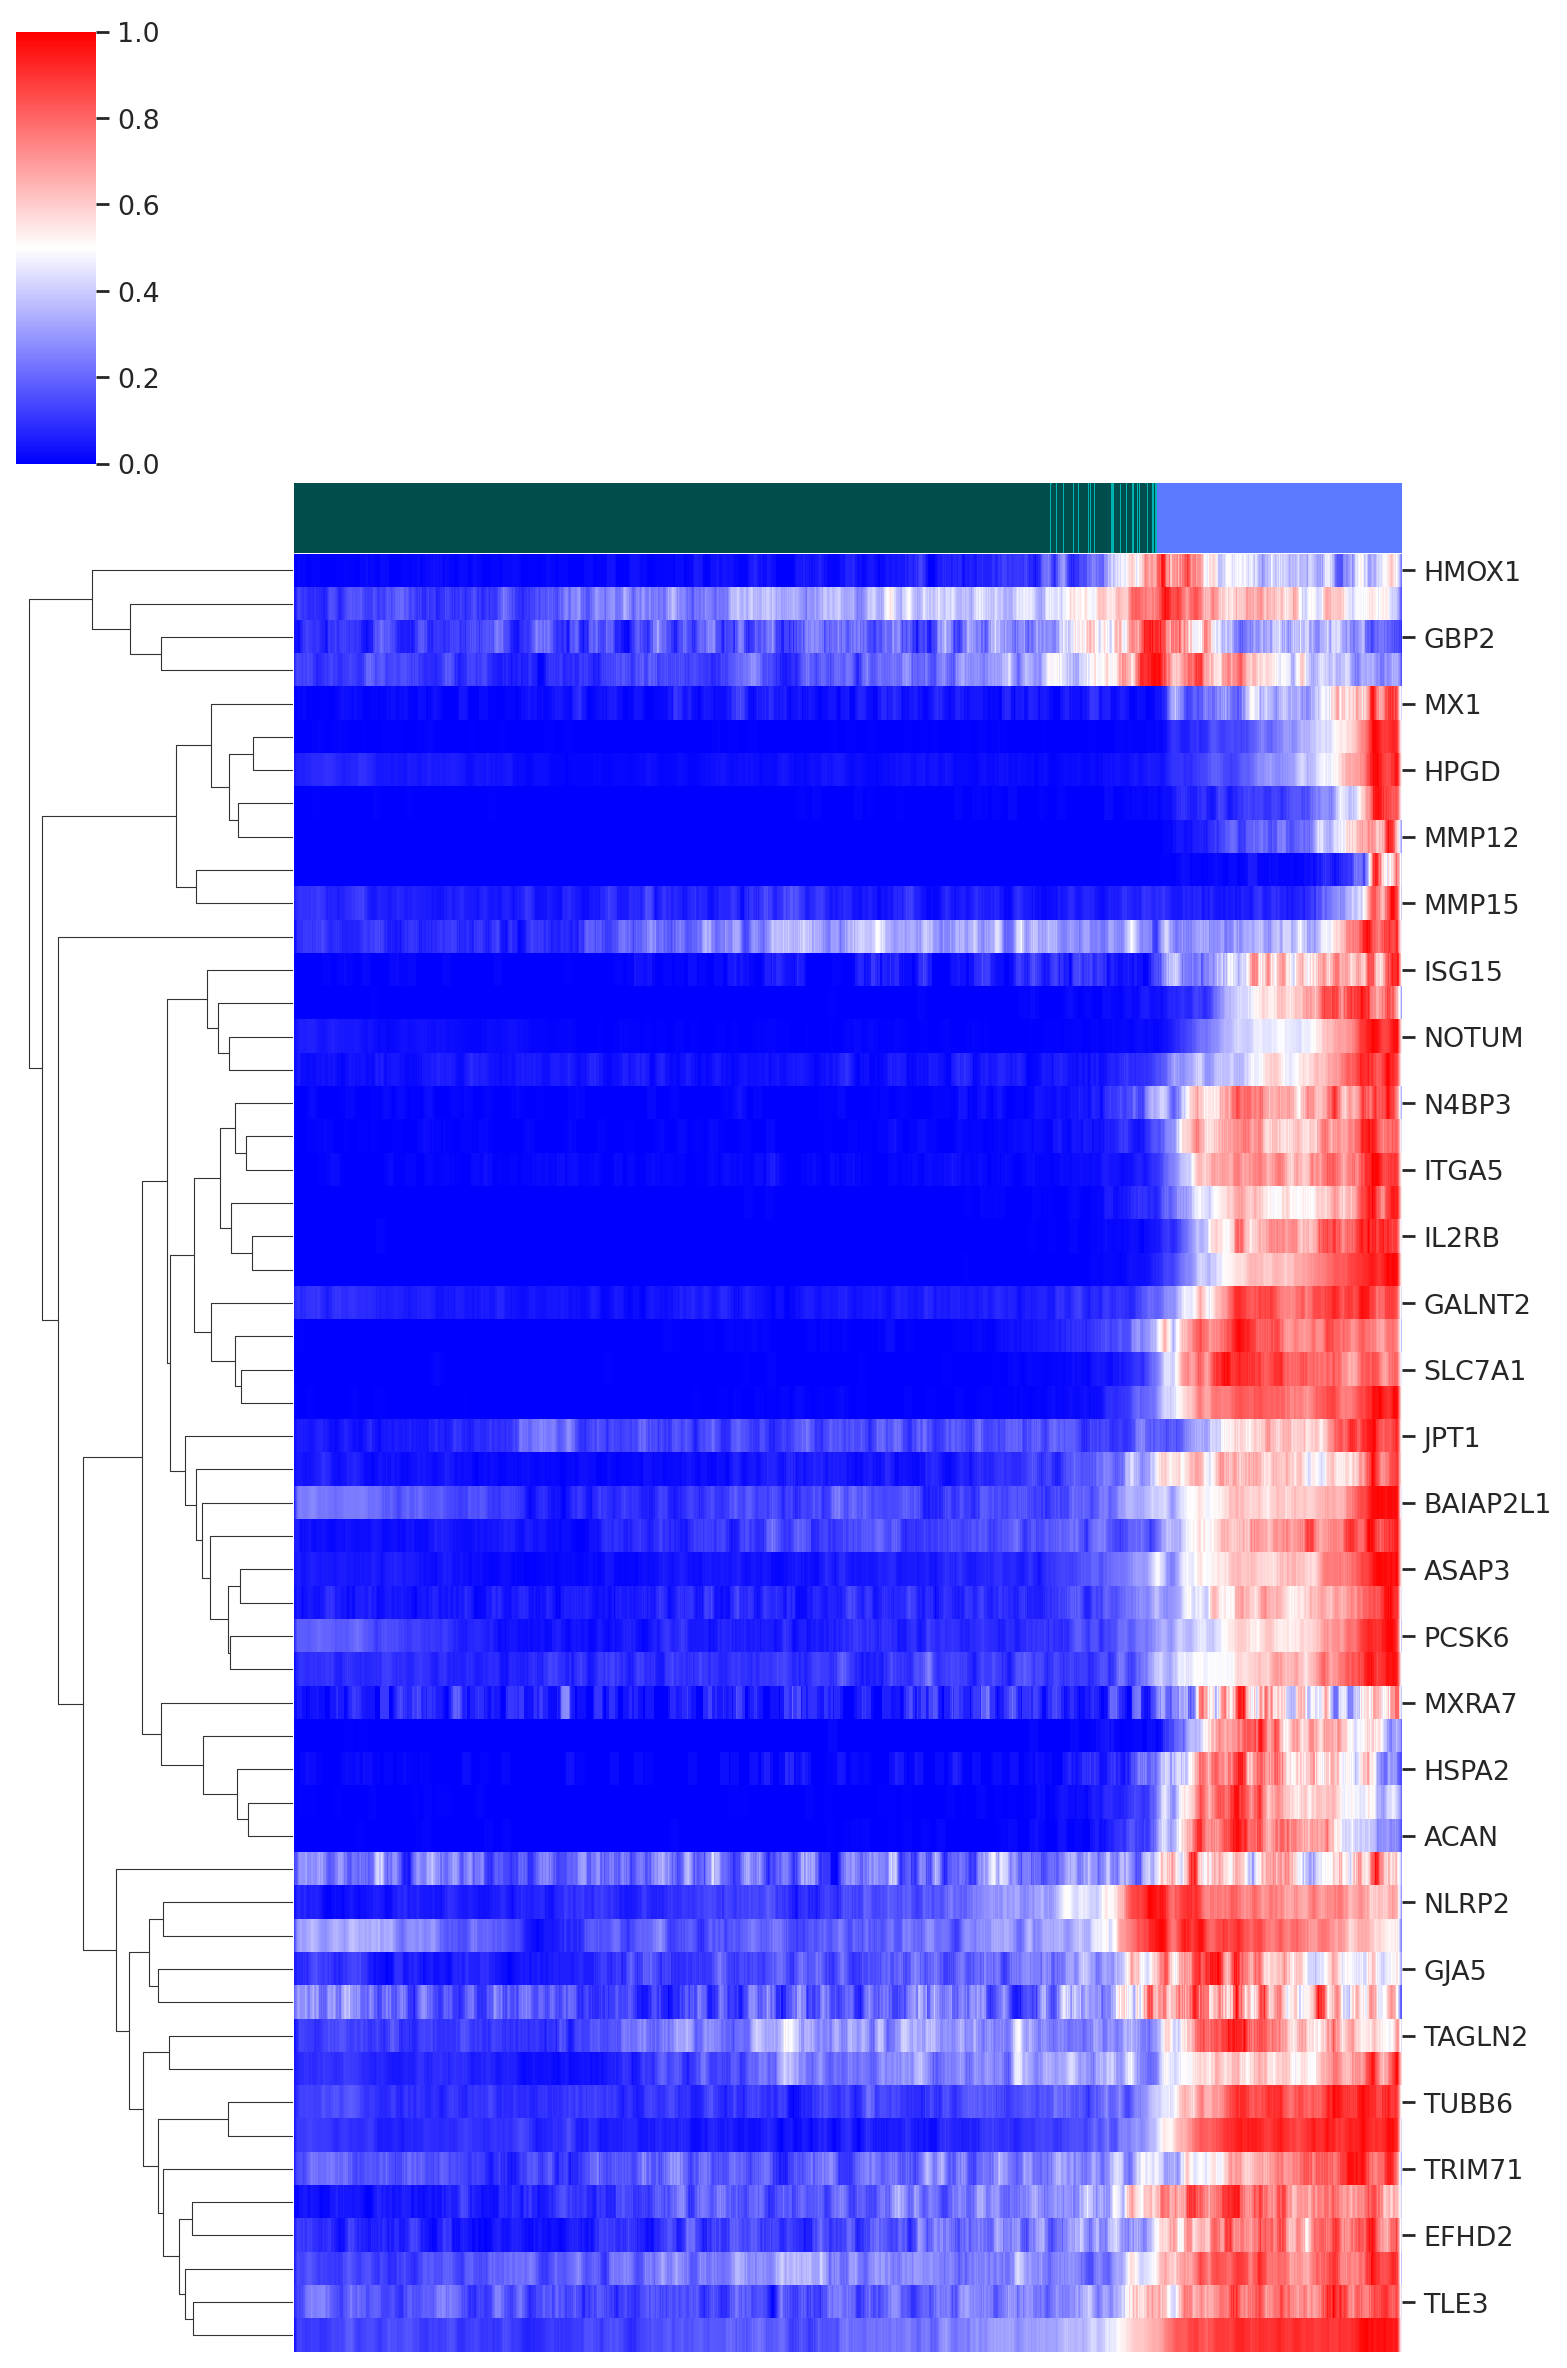

In [42]:
#Print the vCCT heatmap with colorbar too (Extended figure 4h)
scv.pl.heatmap(adata_evt, var_names=evt_pseudotime_proteomics, sortby='S4_pseudotime', col_color='celltype_v5',
              n_convolve=100, figsize=(10, 15), color_map= 'bwr', row_cluster=True, cbar_pos=True, colorbar=True) #save= '_vCCT_leaf_proteomics_100622.pdf'